# Proyecto 1

- Daniel Alfredo Rayo Roldán
- Andre Yatmian Jo
- Flavio André Galán Donis

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.animation import FuncAnimation
import time
import copy
from itertools import islice
import math

### Parámetros globales

In [12]:
N = 100
MAX_ITER = 600
SELECTION_PERCENTAGE = 0.3
KEEP_PERFORMANCE_PERCENTAGE = 0.08
MUTATION_PERCENTAGE = 0.3
CROSSOVER_PERCENTAGE = 0.7

### Cargado de datos

Los datos de las ciudades son cargados en una matriz de adjacencia entre las ciudadades, la intersección entre columnas y filas representa el costo de viajar de la entre cada ciudad. 

La **matriz de adjacencia es simétrica** es decir, que recorrer de A a B tiene el mismo costo que recorrer de B a A.

In [13]:
def get_adjacency_matrix(path):
    CITIES_COORDINATES = []
    with open(path, "r") as f:
        for line in islice(f, 6, None):  # skip first 6 lines
            parts = line.split()
            
            # check length before accessing index 2
            if len(parts) >= 3:
                parts[2] = parts[2].strip()
                CITIES_COORDINATES.append([float(parts[1]),float(parts[2]) ])
            
    CITIES_COORDINATES = np.array(CITIES_COORDINATES)

    ADJACENCY_MATRIX = np.array([

    ])

    # --- Calcular matriz de distancias ---
    # CITIES_COORDINATES is a numpy array (n, 2)
    n = CITIES_COORDINATES.shape[0]

    ADJACENCY_MATRIX = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                x1, y1 = CITIES_COORDINATES[i]
                x2, y2 = CITIES_COORDINATES[j]
                ADJACENCY_MATRIX[i, j] = round(math.dist((x1, y1), (x2, y2)), 2)

    np.fill_diagonal(ADJACENCY_MATRIX, 1.0)

    return (CITIES_COORDINATES, ADJACENCY_MATRIX)

# Las filas de la matriz de adjacencia estan en el mismo 
# orden que la lista de coordenadas de cada ciudad
CITIES_COORDINATES, ADJACENCY_MATRIX = get_adjacency_matrix("data/eil101.tsp")

np.set_printoptions(precision=2, suppress=True)
print("Matriz de adjacencia:")
print(ADJACENCY_MATRIX)
print("\nCoordinadas de cada ciudad:")
print(CITIES_COORDINATES)

Matriz de adjacencia:
[[ 1.   32.56 14.56 ... 31.14 38.6  15.23]
 [32.56  1.   34.41 ... 17.49 17.03 18.  ]
 [14.56 34.41  1.   ... 39.82 45.8  22.36]
 ...
 [31.14 17.49 39.82 ...  1.    8.25 17.49]
 [38.6  17.03 45.8  ...  8.25  1.   24.04]
 [15.23 18.   22.36 ... 17.49 24.04  1.  ]]

Coordinadas de cada ciudad:
[[41. 49.]
 [35. 17.]
 [55. 45.]
 [55. 20.]
 [15. 30.]
 [25. 30.]
 [20. 50.]
 [10. 43.]
 [55. 60.]
 [30. 60.]
 [20. 65.]
 [50. 35.]
 [30. 25.]
 [15. 10.]
 [30.  5.]
 [10. 20.]
 [ 5. 30.]
 [20. 40.]
 [15. 60.]
 [45. 65.]
 [45. 20.]
 [45. 10.]
 [55.  5.]
 [65. 35.]
 [65. 20.]
 [45. 30.]
 [35. 40.]
 [41. 37.]
 [64. 42.]
 [40. 60.]
 [31. 52.]
 [35. 69.]
 [53. 52.]
 [65. 55.]
 [63. 65.]
 [ 2. 60.]
 [20. 20.]
 [ 5.  5.]
 [60. 12.]
 [40. 25.]
 [42.  7.]
 [24. 12.]
 [23.  3.]
 [11. 14.]
 [ 6. 38.]
 [ 2. 48.]
 [ 8. 56.]
 [13. 52.]
 [ 6. 68.]
 [47. 47.]
 [49. 58.]
 [27. 43.]
 [37. 31.]
 [57. 29.]
 [63. 23.]
 [53. 12.]
 [32. 12.]
 [36. 26.]
 [21. 24.]
 [17. 34.]
 [12. 24.]
 [24. 58.]
 [2

In [14]:
NUM_CITIES = len(ADJACENCY_MATRIX)
print("No ciudades:" + str(NUM_CITIES))

No ciudades:101


## Algoritmos de genético

In [15]:
## FUNCIONES DE UTILIDAD

def calculate_route_distance(route, adj_matrix):
    distance = 0
    for i in range(len(route)):
        from_city = route[i]
        to_city = route[(i + 1) % len(route)]
        distance += adj_matrix[from_city][to_city]
    return distance

def create_random_route():
    route = list(range(NUM_CITIES))
    random.shuffle(route)
    return route

In [16]:
## FUNCIONES PARA GRAFICAR

def plot_tsp_convergence(best_distances_history, best_route, cities_coordinates):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(best_distances_history)
    plt.title('Algorithm Convergence')
    plt.xlabel('Generation')
    plt.ylabel('Best Distance')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.title(f'Best Route (Distance: {best_distances_history[-1]:.2f})')
    
    x_coords = cities_coordinates[:, 0]
    y_coords = cities_coordinates[:, 1]
    
    route_x = [x_coords[city] for city in best_route] + [x_coords[best_route[0]]]
    route_y = [y_coords[city] for city in best_route] + [y_coords[best_route[0]]]
    
    plt.plot(route_x, route_y, 'b-', alpha=0.7, linewidth=2)
    plt.scatter(x_coords, y_coords, c='red', s=100, zorder=5)
    
    for i, (x, y) in enumerate(zip(x_coords, y_coords)):
        plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_tsp_animation(best_routes_history, best_distances_history, cities_coordinates, 
                        interval=200, save_path=None):
    print("Creating animation...")
    
    step = max(1, len(best_routes_history) // 50)
    sampled_routes = best_routes_history[::step]
    sampled_distances = best_distances_history[::step]
    
    x_coords = cities_coordinates[:, 0]
    y_coords = cities_coordinates[:, 1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    def animate(frame):
        ax1.clear()
        ax2.clear()
        
        ax1.plot(best_distances_history[:frame*step+1], 'b-', linewidth=2)
        ax1.scatter(frame*step, sampled_distances[frame], color='red', s=100, zorder=5)
        ax1.set_title(f'Convergence (Generation {frame*step})')
        ax1.set_xlabel('Generation')
        ax1.set_ylabel('Best Distance')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(min(best_distances_history) * 0.95, 
                    max(best_distances_history) * 1.05)
        
        current_route = sampled_routes[frame]
        route_x = [x_coords[city] for city in current_route] + [x_coords[current_route[0]]]
        route_y = [y_coords[city] for city in current_route] + [y_coords[current_route[0]]]
        
        ax2.plot(route_x, route_y, 'b-', linewidth=2, alpha=0.7)
        ax2.scatter(x_coords, y_coords, c='red', s=100, zorder=5)
        
        for i, (x, y) in enumerate(zip(x_coords, y_coords)):
            ax2.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
        
        ax2.set_title(f'Best Route - Distance: {sampled_distances[frame]:.2f}')
        ax2.set_xlabel('X Coordinate')
        ax2.set_ylabel('Y Coordinate')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
    
    anim = FuncAnimation(fig, animate, frames=len(sampled_routes), 
                       interval=interval, repeat=True, blit=False)
    
    if save_path:
        print(f"Saving animation to {save_path}...")
        anim.save(save_path, writer='pillow', fps=5)
        print("Animation saved!")
    
    plt.show()
    return anim

In [17]:
import random, time
import numpy as np
from collections import defaultdict

# ==== Utilidades de validación / reparación ====
def is_permutation(route, n):
    if len(route) != n: 
        return False
    seen = [False]*n
    for v in route:
        if not (0 <= v < n) or seen[v]:
            return False
        seen[v] = True
    return True

def repair_route(route, n):
    """Elimina duplicados, conserva primer aparición y añade faltantes en orden natural."""
    seen = [False]*n
    fixed = []
    for v in route:
        if 0 <= v < n and not seen[v]:
            fixed.append(v)
            seen[v] = True
    # agrega faltantes
    for v in range(n):
        if not seen[v]:
            fixed.append(v)
    return fixed

def sanitize_population(pop, n):
    """Repara cualquier ruta inválida en la población."""
    out = []
    for r in pop:
        if not is_permutation(r, n):
            out.append(repair_route(r, n))
        else:
            out.append(r)
    return out


class TSPGeneticAlgorithm:
    def __init__(self, adjacency_matrix, coords):
        # inputs
        self.matrix = adjacency_matrix
        self.coords = coords

        # state
        self.population = []
        self.fitness_scores = []
        self.best_routes_history = []
        self.best_distances_history = []
        self.generation = 0
        self.distances = []
        self.timeduration = 0

        # helpers
        self.n = len(adjacency_matrix)
        self.cand_lists = self.build_candidate_lists(self.matrix, k=min(25, max(10, self.n//4)))
        self.mut_rate = MUTATION_PERCENTAGE  # adaptativa

    # ---------- Constructores greedy ----------
    @staticmethod
    def nearest_neighbor_route(matrix, start=0):
        n = len(matrix)
        unvisited = set(range(n))
        route = [start]
        unvisited.remove(start)
        curr = start
        while unvisited:
            nxt = min(unvisited, key=lambda j: matrix[curr][j])
            route.append(nxt)
            unvisited.remove(nxt)
            curr = nxt
        return route

    @staticmethod
    def cheapest_insertion_route(matrix):
        n = len(matrix)
        if n < 2:
            return list(range(n))
        route = [0, 1]
        remaining = list(range(2, n))
        while remaining:
            best = None
            for v in remaining:
                best_pos, best_delta = None, float('inf')
                for i in range(len(route)):
                    a, b = route[i], route[(i + 1) % len(route)]
                    delta = matrix[a][v] + matrix[v][b] - matrix[a][b]
                    if delta < best_delta:
                        best_delta, best_pos = delta, i + 1
                if best is None or best_delta < best[2]:
                    best = (v, best_pos, best_delta)
            v, pos, _ = best
            route.insert(pos, v)
            remaining.remove(v)
        return route

    # ---------- Init población (con saneo) ----------
    def initialize_population(self):
        if N <= 0 or MAX_ITER <= 0:
            raise ValueError("N y MAX_ITER deben ser > 0.")
        print("Initializing population...")

        greedy_frac = 0.40
        gN = int(max(0, min(N, greedy_frac * N)))

        greedy_routes = []
        starts = list(range(min(gN, self.n)))
        # mitad NN, mitad cheapest
        for s in starts[: max(1, gN // 2)]:
            greedy_routes.append(self.nearest_neighbor_route(self.matrix, start=s))
        for _ in range(max(0, gN - len(greedy_routes))):
            greedy_routes.append(self.cheapest_insertion_route(self.matrix))

        random_routes = [create_random_route() for _ in range(max(0, N - len(greedy_routes)))]
        self.population = greedy_routes + random_routes

        # Sanea por si acaso
        self.population = sanitize_population(self.population, self.n)
        self.evaluate_fitness()

    # ---------- Fitness ----------
    def evaluate_fitness(self):
        self.fitness_scores = []
        distances = []
        for route in self.population:
            # Asegura rutas válidas (defensivo)
            if not is_permutation(route, self.n):
                route = repair_route(route, self.n)
            distance = calculate_route_distance(route, self.matrix)
            distances.append(distance)
            self.fitness_scores.append(1.0 / (distance + 1e-9))

        best_idx = int(np.argmin(distances)) if distances else 0
        if distances:
            self.best_routes_history.append(self.population[best_idx].copy())
            self.best_distances_history.append(distances[best_idx])

    # ---------- Selección ----------
    def selection(self):
        sorted_indices = np.argsort(self.fitness_scores)[::-1]
        num_selected = max(2, int(N * SELECTION_PERCENTAGE))
        selected_indices = sorted_indices[:num_selected]
        selected_population = [self.population[i] for i in selected_indices]
        selected_fitness = [self.fitness_scores[i] for i in selected_indices]
        return selected_population, selected_fitness

    def tournament_selection(self, population, fitness_scores, tournament_size=3):
        tsize = min(max(2, tournament_size), len(population))
        indices = random.sample(range(len(population)), tsize)
        winner_idx = max(indices, key=lambda i: fitness_scores[i])
        return population[winner_idx]

    # ---------- ERX robusto ----------
    @staticmethod
    def _build_edge_table(p1, p2):
        n = len(p1)
        edges = defaultdict(set)
        def add_neighbors(p):
            for i, city in enumerate(p):
                left = p[(i - 1) % n]
                right = p[(i + 1) % n]
                edges[city].add(left)
                edges[city].add(right)
        add_neighbors(p1)
        add_neighbors(p2)
        return edges

    def erx_crossover(self, p1, p2):
        # Repara padres si no son permutaciones
        if not is_permutation(p1, self.n):
            p1 = repair_route(p1, self.n)
        if not is_permutation(p2, self.n):
            p2 = repair_route(p2, self.n)

        n = len(p1)
        domain = set(range(n))
        edges = self._build_edge_table(p1, p2)

        curr = p1[0]
        child = [curr]
        used = {curr}

        while len(child) < n:
            # quitar curr de las listas de adyacencia
            for s in edges.values():
                s.discard(curr)

            cand = edges[curr]
            nxt = None
            if cand:
                # el vecino con menor grado
                viable = [c for c in cand if c not in used]
                if viable:
                    nxt = min(viable, key=lambda c: len(edges[c]))

            if nxt is None:
                # fallback: escoger de los no usados con menor grado
                unused = list(domain - used)
                if not unused:
                    # súper fallback: reconstruir desde dominio y cortar el bucle
                    break
                nxt = min(unused, key=lambda c: len(edges[c]))

            child.append(nxt)
            used.add(nxt)
            curr = nxt

        # Si por algún motivo no completó, añade faltantes
        if len(child) < n:
            for v in range(n):
                if v not in used:
                    child.append(v)
                    used.add(v)

        # Garantiza permutación
        if not is_permutation(child, n):
            child = repair_route(child, n)

        return child

    # ---------- Mutación (adaptativa) ----------
    def mutate(self, route):
        r = route.copy()
        if random.random() < self.mut_rate:
            if random.random() < 0.7:  # swap
                i, j = random.sample(range(len(r)), 2)
                r[i], r[j] = r[j], r[i]
            else:  # 3-segment shuffle
                i, j, k = sorted(random.sample(range(len(r)), 3))
                r[i:j], r[j:k] = r[j:k], r[i:j]
        return r

    def adapt_mutation(self, improved):
        if improved:
            self.mut_rate = max(0.01, self.mut_rate * 0.95)
        else:
            self.mut_rate = min(0.30, self.mut_rate * 1.05)

    # ---------- 2-opt con listas candidatas ----------
    @staticmethod
    def build_candidate_lists(matrix, k=20):
        n = len(matrix)
        lists = []
        for i in range(n):
            order = sorted(
                range(n),
                key=lambda j: matrix[i][j] if i != j else float('inf')
            )
            lists.append(order[:min(k, max(1, n-1))])
        return lists

    def two_opt(self, route):
        n = len(route)
        best = route
        improved = True
        while improved:
            improved = False
            for i in range(n - 1):
                a, b = best[i], best[(i + 1) % n]
                neigh = set(self.cand_lists[a]) | set(self.cand_lists[b])
                k_range = range(i + 2, n if i > 0 else n - 1)
                for k in k_range:
                    c, d = best[k], best[(k + 1) % n]
                    if c not in neigh and d not in neigh:
                        continue
                    delta = (self.matrix[a][c] + self.matrix[b][d]) - (self.matrix[a][b] + self.matrix[c][d])
                    if delta < -1e-12:
                        best = best[:i + 1] + best[i + 1:k + 1][::-1] + best[k + 1:]
                        improved = True
                        break
                if improved:
                    break
        return best

    def _route_length(self, r):
        n = len(r)
        return sum(self.matrix[r[i]][r[(i + 1) % n]] for i in range(n))

    # ---------- Elite único + inmigrantes ----------
    @staticmethod
    def _tour_edges(route):
        return frozenset((route[i], route[(i + 1) % len(route)]) for i in range(len(route)))

    def get_elite_unique(self, K):
        pairs = list(zip(self.population, self.fitness_scores))
        pairs.sort(key=lambda x: x[1], reverse=True)
        elites, seen = [], set()
        for r, _ in pairs:
            rr = r if is_permutation(r, self.n) else repair_route(r, self.n)
            E = self._tour_edges(rr)
            if E not in seen:
                elites.append(rr)
                seen.add(E)
            if len(elites) == K:
                break
        if not elites:
            elites = [repair_route(self.population[np.argmax(self.fitness_scores)], self.n)]
        return elites

    def inject_immigrants(self, frac=0.10):
        m = max(1, int(N * frac))
        immigrants = [repair_route(create_random_route(), self.n) for _ in range(m)]
        immigrants = [self.two_opt(r) for r in immigrants]
        idx = np.argsort(self.fitness_scores)[:m]
        for i, ind in zip(idx, immigrants):
            self.population[i] = ind

    # ---------- Generación ----------
    def create_new_generation(self):
        # sanea población actual antes de cruzar
        self.population = sanitize_population(self.population, self.n)

        selected_population, selected_fitness = self.selection()
        new_population = []

        elite_count = max(1, int(N * KEEP_PERFORMANCE_PERCENTAGE))
        elites = self.get_elite_unique(elite_count)
        new_population.extend(elites)

        while len(new_population) < N:
            p1 = self.tournament_selection(selected_population, selected_fitness)
            p2 = self.tournament_selection(selected_population, selected_fitness)
            if p1 == p2 and len(selected_population) > 1:
                p2 = random.choice(selected_population)

            if random.random() < CROSSOVER_PERCENTAGE:
                child = self.erx_crossover(p1, p2)
            else:
                child = p1.copy()

            child = self.mutate(child)
            child = repair_route(child, self.n)   # asegura permutación
            child = self.two_opt(child)           # mejora local
            new_population.append(child)

        self.population = sanitize_population(new_population[:N], self.n)

    # ---------- Loop principal ----------
    def run(self):
        print(f"Starting TSP Genetic Algorithm with {self.n} cities...")
        print(f"Population: {N}, Max Iterations: {MAX_ITER}")
        print("-" * 60)

        start_time = time.time()
        self.initialize_population()

        prev_best = None
        stuck = 0

        for generation in range(MAX_ITER):
            self.generation = generation
            self.create_new_generation()
            self.evaluate_fitness()

            curr_best = self.best_distances_history[-1]
            improved = (prev_best is None) or (curr_best < prev_best - 1e-12)
            self.adapt_mutation(improved)
            if improved:
                prev_best = curr_best
                stuck = 0
            else:
                stuck += 1
                if stuck % 50 == 0:
                    self.inject_immigrants(frac=0.10)

            if generation % 50 == 0:
                print(f"Generation {generation:3d}: Best Distance = {curr_best:.4f}")
                self.distances.append(curr_best)

        end_time = time.time()
        self.timeduration = end_time - start_time
        print(f"\nAlgorithm completed in {self.timeduration:.3f} seconds")
        print(f"Best distance found: {min(self.best_distances_history):.4f}")

    # ---------- Viz (stubs si no las usas) ----------
    def plot_convergence(self):
        plot_tsp_convergence(self.best_distances_history, self.best_routes_history[-1], self.coords)

    def create_animation(self, interval=200, save_path=None):
        create_tsp_animation(self.best_routes_history, self.best_distances_history, self.coords, interval, save_path)


Historial

In [18]:
import matplotlib.pyplot as plt

def save_best_route_image(coords, best_route, best_distance, out_path="best_route.png"):
    closed_route = best_route + [best_route[0]]
    xs = [coords[i][0] for i in closed_route]
    ys = [coords[i][1] for i in closed_route]

    plt.figure(figsize=(6,6))
    plt.plot(xs, ys, 'b-', linewidth=1.5)
    plt.scatter(coords[:,0], coords[:,1], c="red")
    plt.scatter([coords[best_route[0],0]], [coords[best_route[0],1]], c="green", s=80, label="Start")
    plt.title(f"Best Route (Distance: {best_distance:.2f})")
    plt.legend()
    plt.savefig(out_path, bbox_inches="tight")
    plt.close()
    print(f"Imagen guardada en {out_path}")


Escenario 1 eil101.tsp

Starting TSP Genetic Algorithm with 101 cities...
Population: 100, Max Iterations: 600
------------------------------------------------------------
Initializing population...
Generation   0: Best Distance = 669.7000
Generation  50: Best Distance = 644.4100
Generation 100: Best Distance = 642.0000
Generation 150: Best Distance = 642.0000
Generation 200: Best Distance = 642.0000
Generation 250: Best Distance = 642.0000
Generation 300: Best Distance = 640.1300
Generation 350: Best Distance = 640.1300
Generation 400: Best Distance = 640.1300
Generation 450: Best Distance = 640.1300
Generation 500: Best Distance = 640.1300
Generation 550: Best Distance = 640.1300

Algorithm completed in 979.950 seconds
Best distance found: 640.1300
Distancia total del mejor recorrido: 640.13


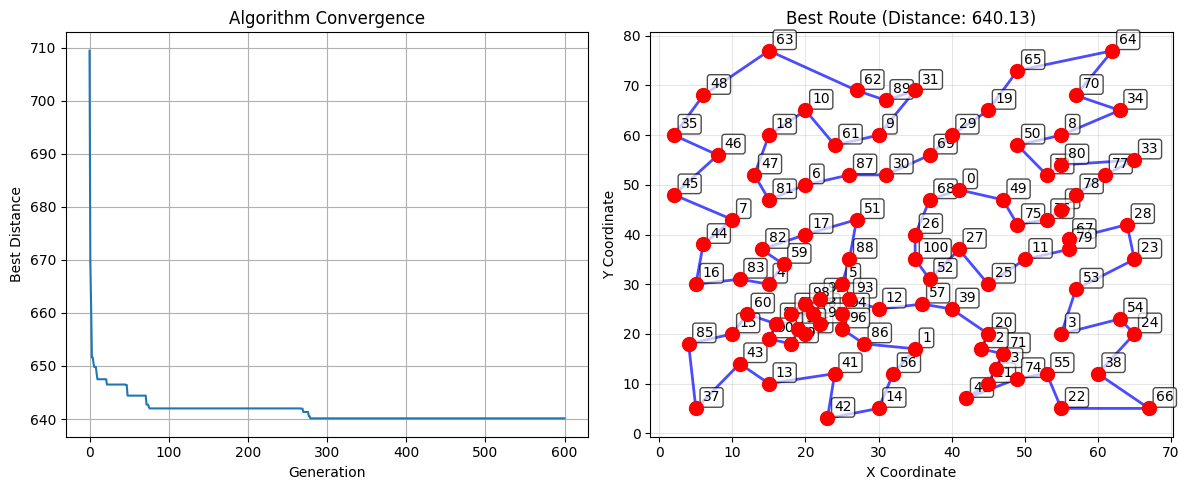

Creating animation...
Saving animation to tspeil_evolution.gif...
Animation saved!


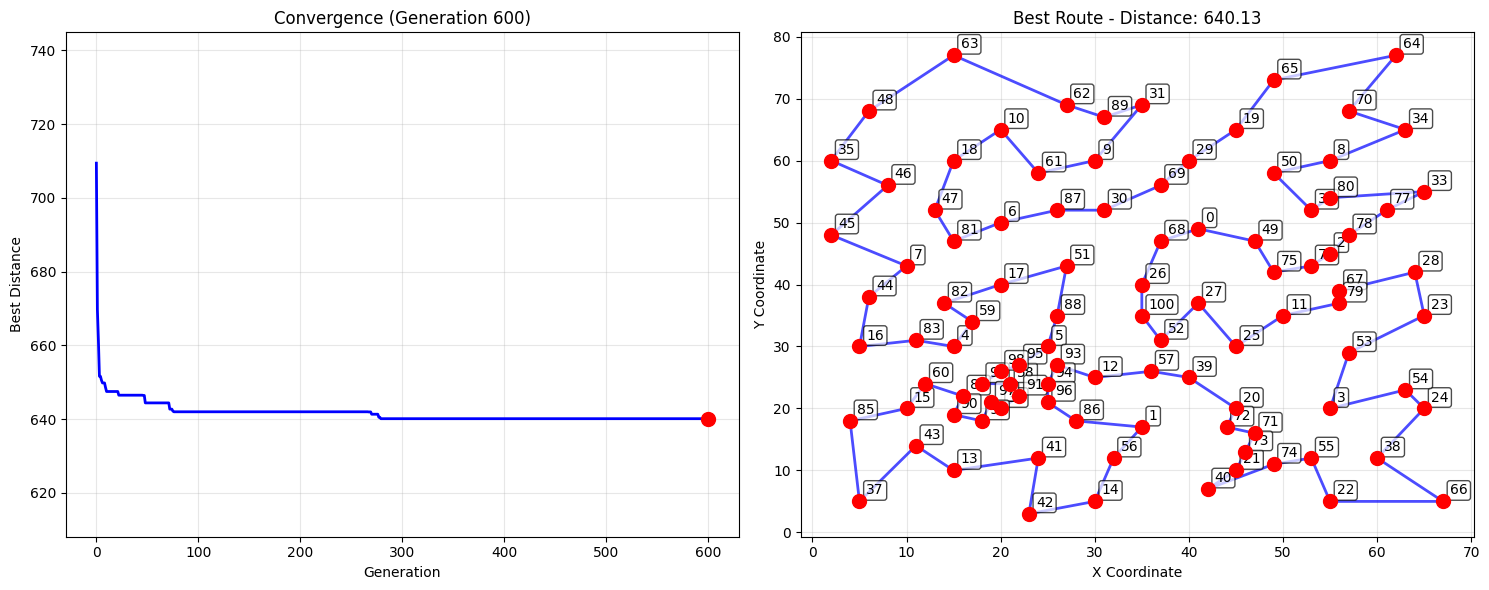

Imagen guardada en out/best_route.png


In [19]:
eil1 = TSPGeneticAlgorithm(ADJACENCY_MATRIX,CITIES_COORDINATES)
eil1.run()

best_routeeil = eil1.best_routes_history[-1]

# Distancia total
Deil1 = calculate_route_distance(best_routeeil, ADJACENCY_MATRIX)
print(f"Distancia total del mejor recorrido: {Deil1:.2f}")

# Plot results
eil1.plot_convergence()

# Create animation (uncomment to generate GIF)
eil1.create_animation(interval=200, save_path='tspeil_evolution.gif')


best_distanceeil1 = min(eil1.best_distances_history)
best_indexeil1 = eil1.best_distances_history.index(best_distanceeil1)
best_routeeil1 = eil1.best_routes_history[best_indexeil1]

save_best_route_image(CITIES_COORDINATES, best_routeeil1, best_distanceeil1, "out/best_route.png")



Escenario 2

Matriz de adjacencia:
[[ 1.   32.56 14.56 ... 31.14 38.6  15.23]
 [32.56  1.   34.41 ... 17.49 17.03 18.  ]
 [14.56 34.41  1.   ... 39.82 45.8  22.36]
 ...
 [31.14 17.49 39.82 ...  1.    8.25 17.49]
 [38.6  17.03 45.8  ...  8.25  1.   24.04]
 [15.23 18.   22.36 ... 17.49 24.04  1.  ]]

Coordinadas de cada ciudad:
[[41. 49.]
 [35. 17.]
 [55. 45.]
 [55. 20.]
 [15. 30.]
 [25. 30.]
 [20. 50.]
 [10. 43.]
 [55. 60.]
 [30. 60.]
 [20. 65.]
 [50. 35.]
 [30. 25.]
 [15. 10.]
 [30.  5.]
 [10. 20.]
 [ 5. 30.]
 [20. 40.]
 [15. 60.]
 [45. 65.]
 [45. 20.]
 [45. 10.]
 [55.  5.]
 [65. 35.]
 [65. 20.]
 [45. 30.]
 [35. 40.]
 [41. 37.]
 [64. 42.]
 [40. 60.]
 [31. 52.]
 [35. 69.]
 [53. 52.]
 [65. 55.]
 [63. 65.]
 [ 2. 60.]
 [20. 20.]
 [ 5.  5.]
 [60. 12.]
 [40. 25.]
 [42.  7.]
 [24. 12.]
 [23.  3.]
 [11. 14.]
 [ 6. 38.]
 [ 2. 48.]
 [ 8. 56.]
 [13. 52.]
 [ 6. 68.]
 [47. 47.]
 [49. 58.]
 [27. 43.]
 [37. 31.]
 [57. 29.]
 [63. 23.]
 [53. 12.]
 [32. 12.]
 [36. 26.]
 [21. 24.]
 [17. 34.]
 [12. 24.]
 [24. 58.]
 [2

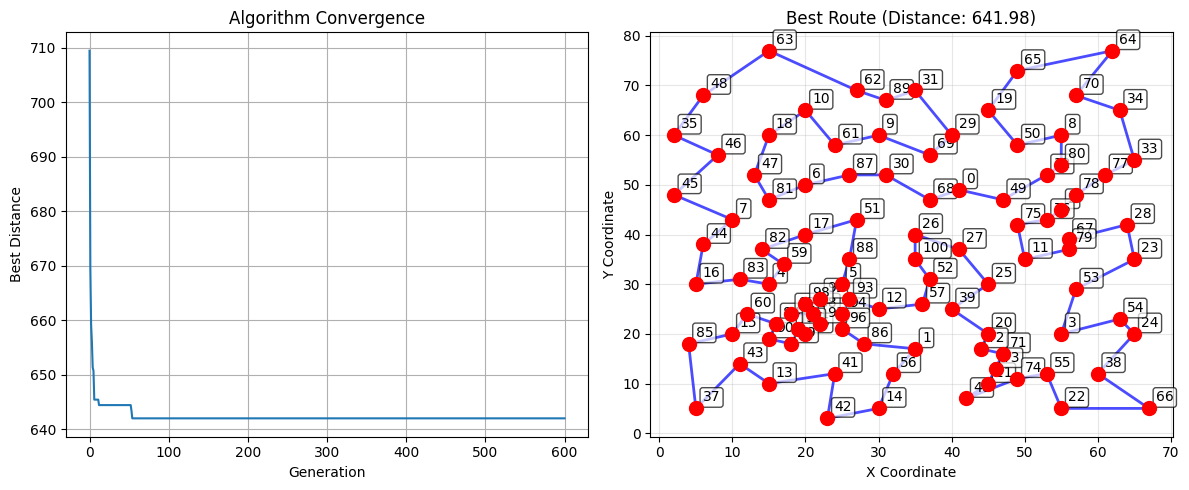

Creating animation...
Saving animation to tspeil2_evolution.gif...
Animation saved!


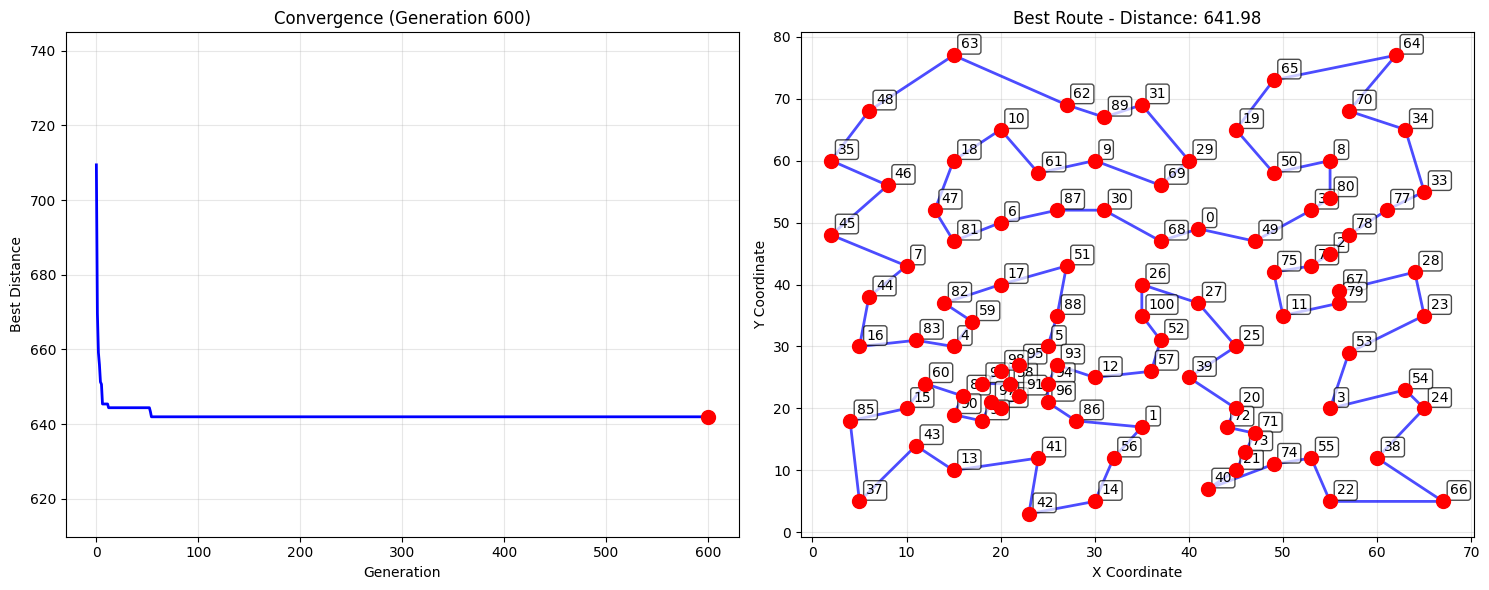

Imagen guardada en out/best_routeeil2.png


In [20]:

CITIES_COORDINATES, ADJACENCY_MATRIX = get_adjacency_matrix("data/eil101.tsp")

np.set_printoptions(precision=2, suppress=True)
print("Matriz de adjacencia:")
print(ADJACENCY_MATRIX)
print("\nCoordinadas de cada ciudad:")
print(CITIES_COORDINATES)
NUM_CITIES = len(ADJACENCY_MATRIX)
print("No ciudades:" + str(NUM_CITIES))

eil2 = TSPGeneticAlgorithm(ADJACENCY_MATRIX,CITIES_COORDINATES)
eil2.run()

best_routeeil2 = eil2.best_routes_history[-1]

# Distancia total
Deil2 = calculate_route_distance(best_routeeil2, ADJACENCY_MATRIX)
print(f"Distancia total del mejor recorrido: {Deil2:.2f}")

# Plot results
eil2.plot_convergence()

# Create animation (uncomment to generate GIF)
eil2.create_animation(interval=200, save_path='tspeil2_evolution.gif')


best_distanceeil2 = min(eil2.best_distances_history)
best_indexeil2 = eil2.best_distances_history.index(best_distanceeil2)
best_routeeil2 = eil2.best_routes_history[best_indexeil2]

save_best_route_image(CITIES_COORDINATES, best_routeeil2, best_distanceeil2, "out/best_routeeil2.png")



Matriz de adjacencia:
[[ 1.   32.56 14.56 ... 31.14 38.6  15.23]
 [32.56  1.   34.41 ... 17.49 17.03 18.  ]
 [14.56 34.41  1.   ... 39.82 45.8  22.36]
 ...
 [31.14 17.49 39.82 ...  1.    8.25 17.49]
 [38.6  17.03 45.8  ...  8.25  1.   24.04]
 [15.23 18.   22.36 ... 17.49 24.04  1.  ]]

Coordinadas de cada ciudad:
[[41. 49.]
 [35. 17.]
 [55. 45.]
 [55. 20.]
 [15. 30.]
 [25. 30.]
 [20. 50.]
 [10. 43.]
 [55. 60.]
 [30. 60.]
 [20. 65.]
 [50. 35.]
 [30. 25.]
 [15. 10.]
 [30.  5.]
 [10. 20.]
 [ 5. 30.]
 [20. 40.]
 [15. 60.]
 [45. 65.]
 [45. 20.]
 [45. 10.]
 [55.  5.]
 [65. 35.]
 [65. 20.]
 [45. 30.]
 [35. 40.]
 [41. 37.]
 [64. 42.]
 [40. 60.]
 [31. 52.]
 [35. 69.]
 [53. 52.]
 [65. 55.]
 [63. 65.]
 [ 2. 60.]
 [20. 20.]
 [ 5.  5.]
 [60. 12.]
 [40. 25.]
 [42.  7.]
 [24. 12.]
 [23.  3.]
 [11. 14.]
 [ 6. 38.]
 [ 2. 48.]
 [ 8. 56.]
 [13. 52.]
 [ 6. 68.]
 [47. 47.]
 [49. 58.]
 [27. 43.]
 [37. 31.]
 [57. 29.]
 [63. 23.]
 [53. 12.]
 [32. 12.]
 [36. 26.]
 [21. 24.]
 [17. 34.]
 [12. 24.]
 [24. 58.]
 [2

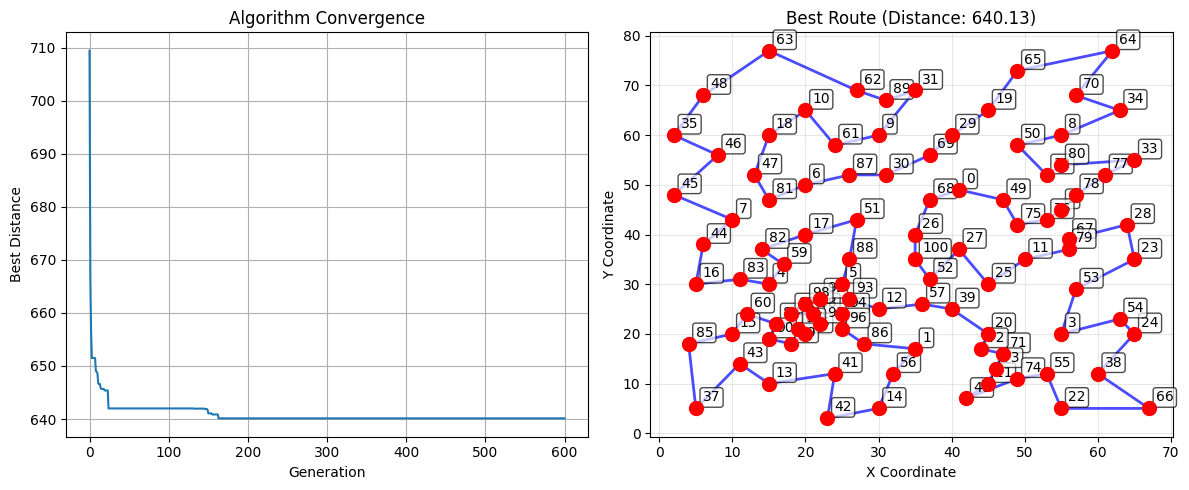

Creating animation...
Saving animation to tspeil3_evolution.gif...
Animation saved!


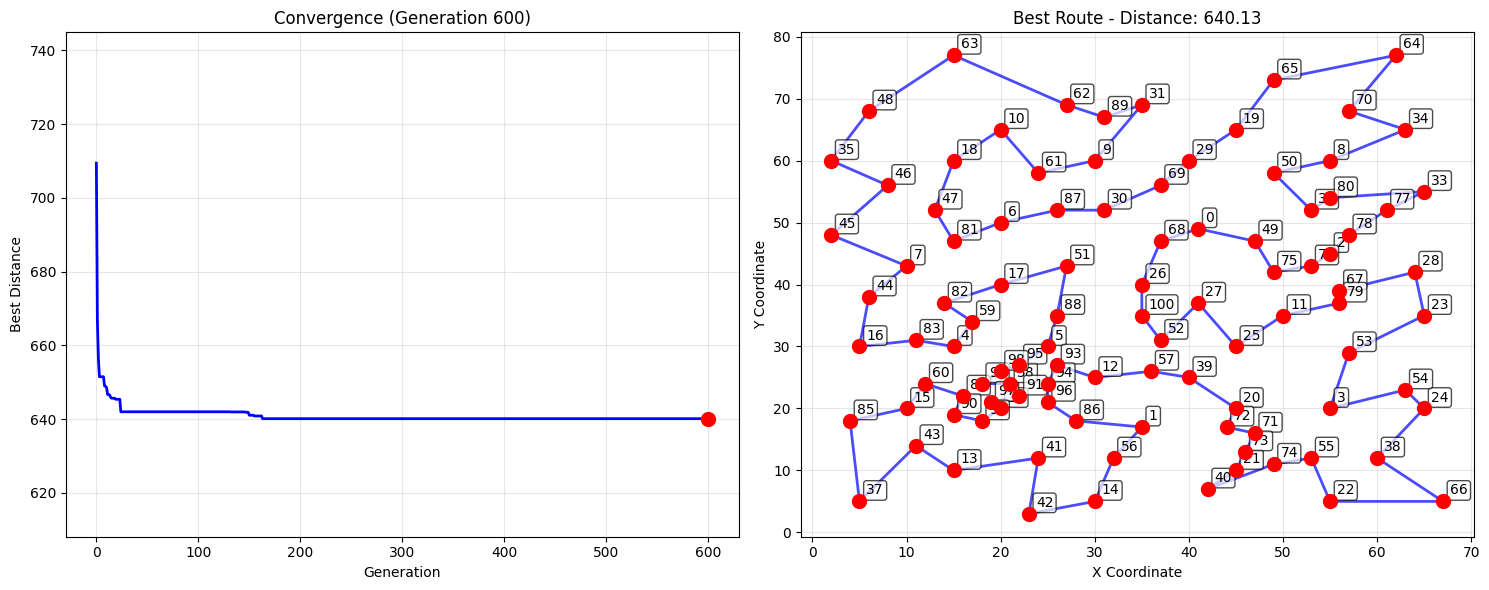

Imagen guardada en out/best_routeeil3.png


In [21]:

CITIES_COORDINATES, ADJACENCY_MATRIX = get_adjacency_matrix("data/eil101.tsp")

np.set_printoptions(precision=2, suppress=True)
print("Matriz de adjacencia:")
print(ADJACENCY_MATRIX)
print("\nCoordinadas de cada ciudad:")
print(CITIES_COORDINATES)
NUM_CITIES = len(ADJACENCY_MATRIX)
print("No ciudades:" + str(NUM_CITIES))

eil3 = TSPGeneticAlgorithm(ADJACENCY_MATRIX,CITIES_COORDINATES)
eil3.run()

best_routeeil3 = eil3.best_routes_history[-1]

# Distancia total
Deil3 = calculate_route_distance(best_routeeil3, ADJACENCY_MATRIX)
print(f"Distancia total del mejor recorrido: {Deil3:.2f}")

# Plot results
eil3.plot_convergence()

# Create animation (uncomment to generate GIF)
eil3.create_animation(interval=200, save_path='tspeil3_evolution.gif')


best_distanceeil3 = min(eil3.best_distances_history)
best_indexeil3 = eil3.best_distances_history.index(best_distanceeil3)
best_routeeil3 = eil3.best_routes_history[best_indexeil3]

save_best_route_image(CITIES_COORDINATES, best_routeeil3, best_distanceeil3, "out/best_routeeil3.png")



Caso Número dos con las ciudades de GR229

In [22]:
CITIES_COORDINATES, ADJACENCY_MATRIX = get_adjacency_matrix("data/gr229.tsp")

np.set_printoptions(precision=2, suppress=True)
print("Matriz de adjacencia:")
print(ADJACENCY_MATRIX)
print("\nCoordenadas de cada ciudad:")
print(CITIES_COORDINATES)

Matriz de adjacencia:
[[  1.     8.42   9.48 ... 201.61 188.07 171.43]
 [  8.42   1.    11.24 ... 206.49 192.4  175.27]
 [  9.48  11.24   1.   ... 195.26 181.17 164.09]
 ...
 [201.61 206.49 195.26 ...   1.    20.77  41.29]
 [188.07 192.4  181.17 ...  20.77   1.    20.94]
 [171.43 175.27 164.09 ...  41.29  20.94   1.  ]]

Coordenadas de cada ciudad:
[[  68.58   33.05]
 [  64.34   40.32]
 [  59.55   30.15]
 [  59.25   24.45]
 [  56.57   24.06]
 [  54.43   20.3 ]
 [  54.41   25.19]
 [  53.54   27.34]
 [  49.5    24.  ]
 [  50.26   30.31]
 [  46.28   30.44]
 [  55.45   37.35]
 [  56.2    44.  ]
 [  55.45   49.08]
 [  53.12   50.09]
 [  51.4    39.1 ]
 [  50.     36.15]
 [  48.27   34.59]
 [  44.36   33.32]
 [  47.14   39.42]
 [  48.44   44.25]
 [  46.21   48.03]
 [  41.43   44.49]
 [  40.11   44.3 ]
 [  40.23   49.51]
 [  58.     56.15]
 [  56.51   60.36]
 [  67.27   63.58]
 [  69.2    88.06]
 [  55.     73.24]
 [  55.02   82.55]
 [  56.01   92.5 ]
 [  49.5    73.1 ]
 [  43.15   76.57]
 [ 

In [23]:
NUM_CITIES = len(ADJACENCY_MATRIX)
print("No ciudades:" + str(NUM_CITIES))

No ciudades:229


Starting TSP Genetic Algorithm with 229 cities...
Population: 100, Max Iterations: 600
------------------------------------------------------------
Initializing population...
Generation   0: Best Distance = 1721.3400
Generation  50: Best Distance = 1644.2500
Generation 100: Best Distance = 1639.0200
Generation 150: Best Distance = 1636.2900
Generation 200: Best Distance = 1636.2900
Generation 250: Best Distance = 1636.2900
Generation 300: Best Distance = 1636.2900
Generation 350: Best Distance = 1635.2300
Generation 400: Best Distance = 1635.2300
Generation 450: Best Distance = 1635.2300
Generation 500: Best Distance = 1635.2300
Generation 550: Best Distance = 1635.2300

Algorithm completed in 5709.514 seconds
Best distance found: 1635.2300
Distancia total del mejor recorrido: 1635.23


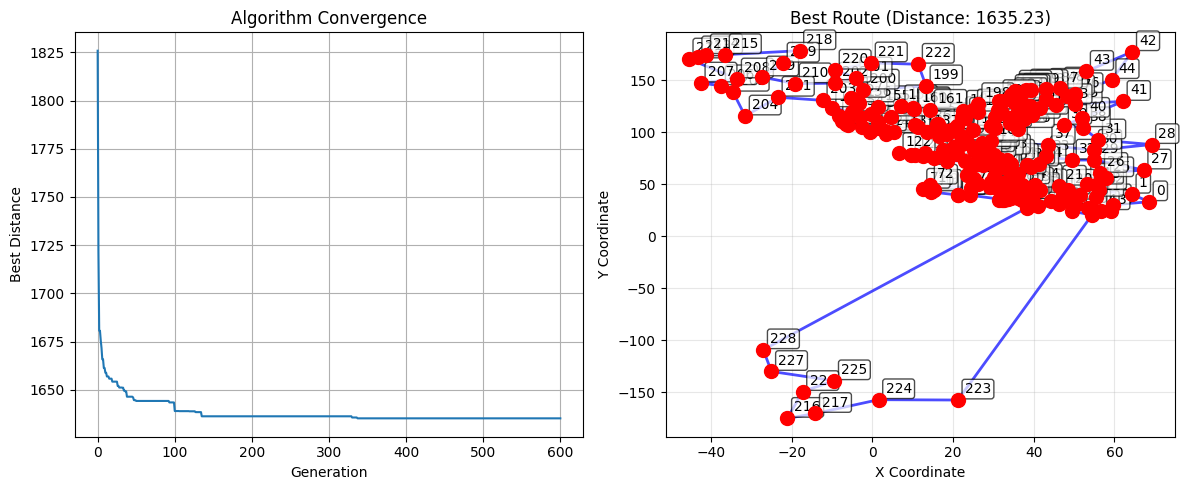

Creating animation...
Saving animation to tsp_gr_evolution.gif...
Animation saved!


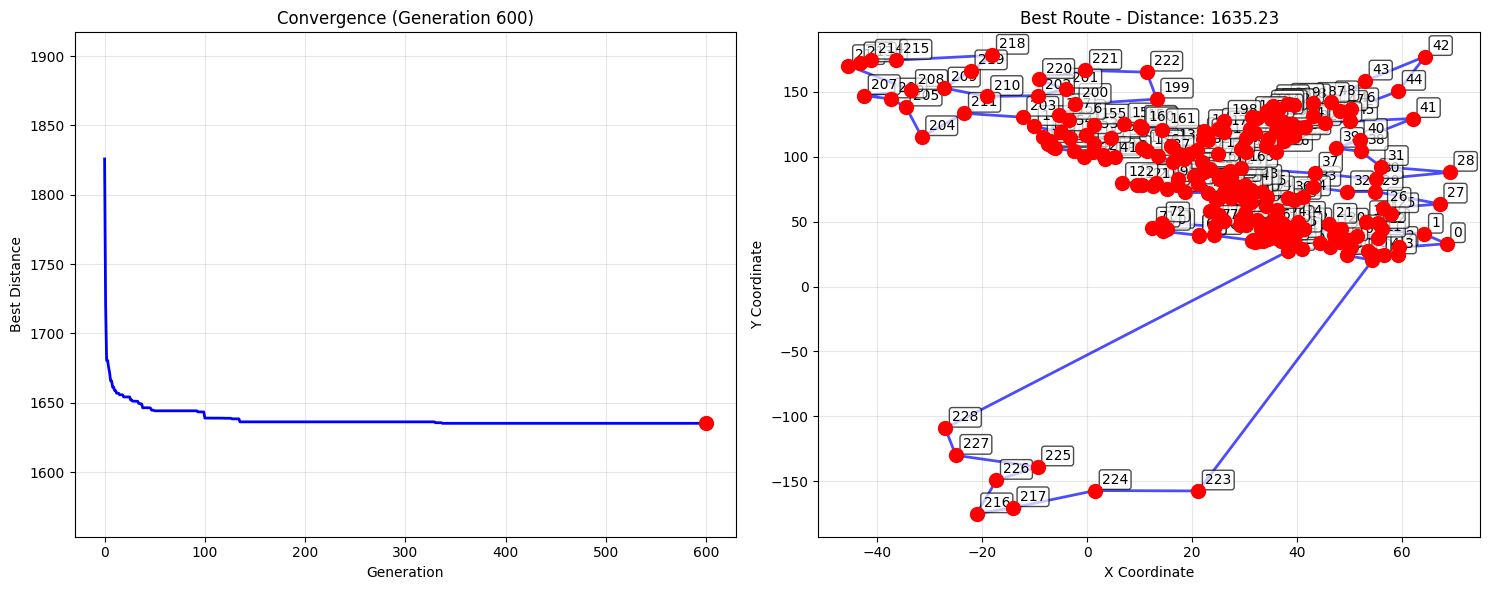

Imagen guardada en out/best1_routegr.png


In [24]:
gr1 = TSPGeneticAlgorithm(ADJACENCY_MATRIX,CITIES_COORDINATES)
gr1.run()

best_routegr1 = gr1.best_routes_history[-1]

# Distancia total
Dgr1 = calculate_route_distance(best_routegr1, ADJACENCY_MATRIX)
print(f"Distancia total del mejor recorrido: {Dgr1:.2f}")

# Plot results
gr1.plot_convergence()

# Create animation (uncomment to generate GIF)
gr1.create_animation(interval=200, save_path='tsp_gr_evolution.gif')



best_distancegr1 = min(gr1.best_distances_history)
best_indexgr1 = gr1.best_distances_history.index(best_distancegr1)
best_routegr1 = gr1.best_routes_history[best_indexgr1]

save_best_route_image(CITIES_COORDINATES, best_routegr1, best_distancegr1, "out/best1_routegr.png")


Escenario 229 2

Matriz de adjacencia:
[[  1.     8.42   9.48 ... 201.61 188.07 171.43]
 [  8.42   1.    11.24 ... 206.49 192.4  175.27]
 [  9.48  11.24   1.   ... 195.26 181.17 164.09]
 ...
 [201.61 206.49 195.26 ...   1.    20.77  41.29]
 [188.07 192.4  181.17 ...  20.77   1.    20.94]
 [171.43 175.27 164.09 ...  41.29  20.94   1.  ]]

Coordenadas de cada ciudad:
[[  68.58   33.05]
 [  64.34   40.32]
 [  59.55   30.15]
 [  59.25   24.45]
 [  56.57   24.06]
 [  54.43   20.3 ]
 [  54.41   25.19]
 [  53.54   27.34]
 [  49.5    24.  ]
 [  50.26   30.31]
 [  46.28   30.44]
 [  55.45   37.35]
 [  56.2    44.  ]
 [  55.45   49.08]
 [  53.12   50.09]
 [  51.4    39.1 ]
 [  50.     36.15]
 [  48.27   34.59]
 [  44.36   33.32]
 [  47.14   39.42]
 [  48.44   44.25]
 [  46.21   48.03]
 [  41.43   44.49]
 [  40.11   44.3 ]
 [  40.23   49.51]
 [  58.     56.15]
 [  56.51   60.36]
 [  67.27   63.58]
 [  69.2    88.06]
 [  55.     73.24]
 [  55.02   82.55]
 [  56.01   92.5 ]
 [  49.5    73.1 ]
 [  43.15   76.57]
 [ 

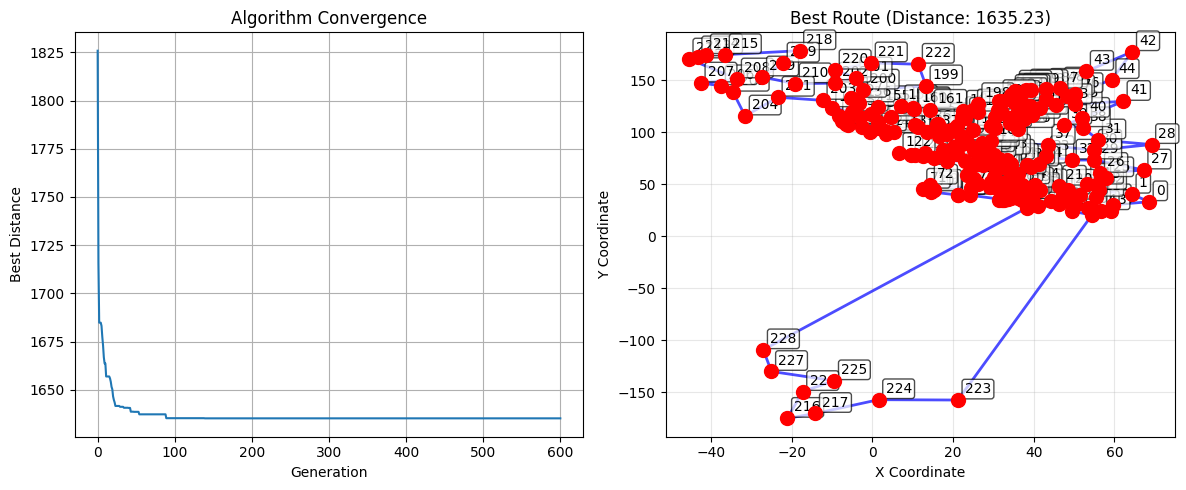

Creating animation...
Saving animation to tsp2_gr_evolution.gif...
Animation saved!


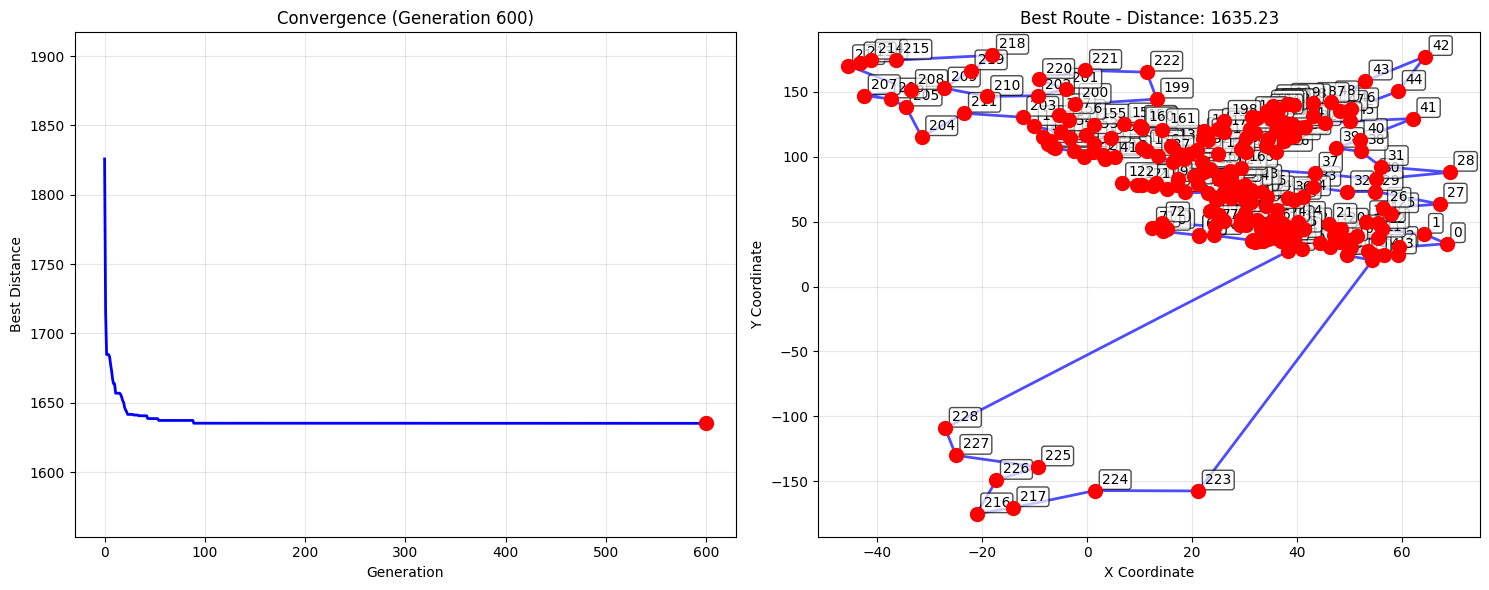

Imagen guardada en out/best2_routegr.png


In [25]:
CITIES_COORDINATES, ADJACENCY_MATRIX = get_adjacency_matrix("data/gr229.tsp")

np.set_printoptions(precision=2, suppress=True)
print("Matriz de adjacencia:")
print(ADJACENCY_MATRIX)
print("\nCoordenadas de cada ciudad:")
print(CITIES_COORDINATES)
NUM_CITIES = len(ADJACENCY_MATRIX)
print("No ciudades:" + str(NUM_CITIES))

gr2 = TSPGeneticAlgorithm(ADJACENCY_MATRIX,CITIES_COORDINATES)
gr2.run()

best_routegr2 = gr2.best_routes_history[-1]

# Distancia total
Dgr2 = calculate_route_distance(best_routegr2, ADJACENCY_MATRIX)
print(f"Distancia total del mejor recorrido: {Dgr2:.2f}")

# Plot results
gr2.plot_convergence()

# Create animation (uncomment to generate GIF)
gr2.create_animation(interval=200, save_path='tsp2_gr_evolution.gif')



best_distancegr2 = min(gr2.best_distances_history)
best_indexgr2 = gr2.best_distances_history.index(best_distancegr2)
best_routegr2 = gr2.best_routes_history[best_indexgr2]

save_best_route_image(CITIES_COORDINATES, best_routegr2, best_distancegr2, "out/best2_routegr.png")


Escenario 3 gr229

Matriz de adjacencia:
[[  1.     8.42   9.48 ... 201.61 188.07 171.43]
 [  8.42   1.    11.24 ... 206.49 192.4  175.27]
 [  9.48  11.24   1.   ... 195.26 181.17 164.09]
 ...
 [201.61 206.49 195.26 ...   1.    20.77  41.29]
 [188.07 192.4  181.17 ...  20.77   1.    20.94]
 [171.43 175.27 164.09 ...  41.29  20.94   1.  ]]

Coordenadas de cada ciudad:
[[  68.58   33.05]
 [  64.34   40.32]
 [  59.55   30.15]
 [  59.25   24.45]
 [  56.57   24.06]
 [  54.43   20.3 ]
 [  54.41   25.19]
 [  53.54   27.34]
 [  49.5    24.  ]
 [  50.26   30.31]
 [  46.28   30.44]
 [  55.45   37.35]
 [  56.2    44.  ]
 [  55.45   49.08]
 [  53.12   50.09]
 [  51.4    39.1 ]
 [  50.     36.15]
 [  48.27   34.59]
 [  44.36   33.32]
 [  47.14   39.42]
 [  48.44   44.25]
 [  46.21   48.03]
 [  41.43   44.49]
 [  40.11   44.3 ]
 [  40.23   49.51]
 [  58.     56.15]
 [  56.51   60.36]
 [  67.27   63.58]
 [  69.2    88.06]
 [  55.     73.24]
 [  55.02   82.55]
 [  56.01   92.5 ]
 [  49.5    73.1 ]
 [  43.15   76.57]
 [ 

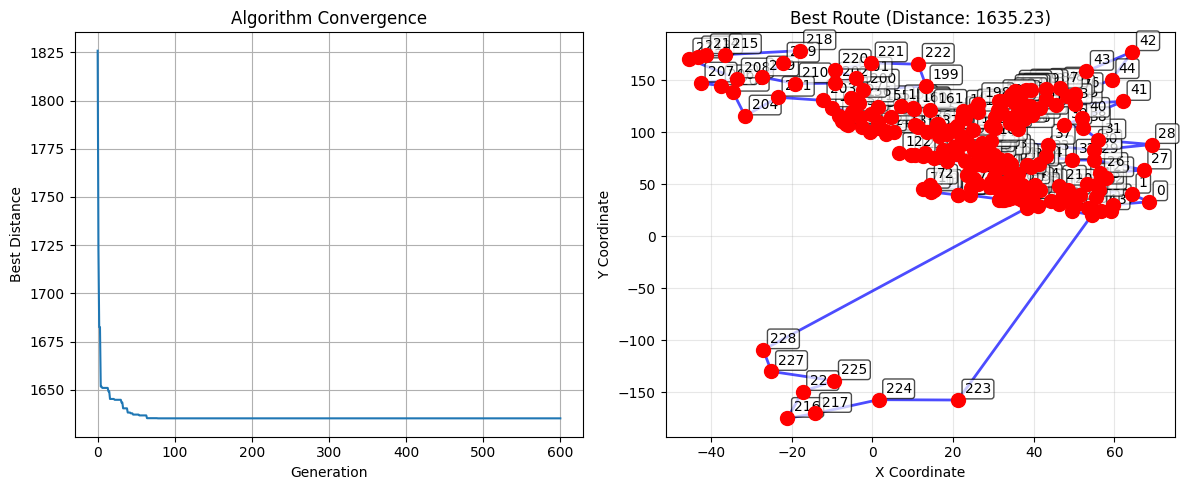

Creating animation...
Saving animation to tsp3_gr_evolution.gif...
Animation saved!


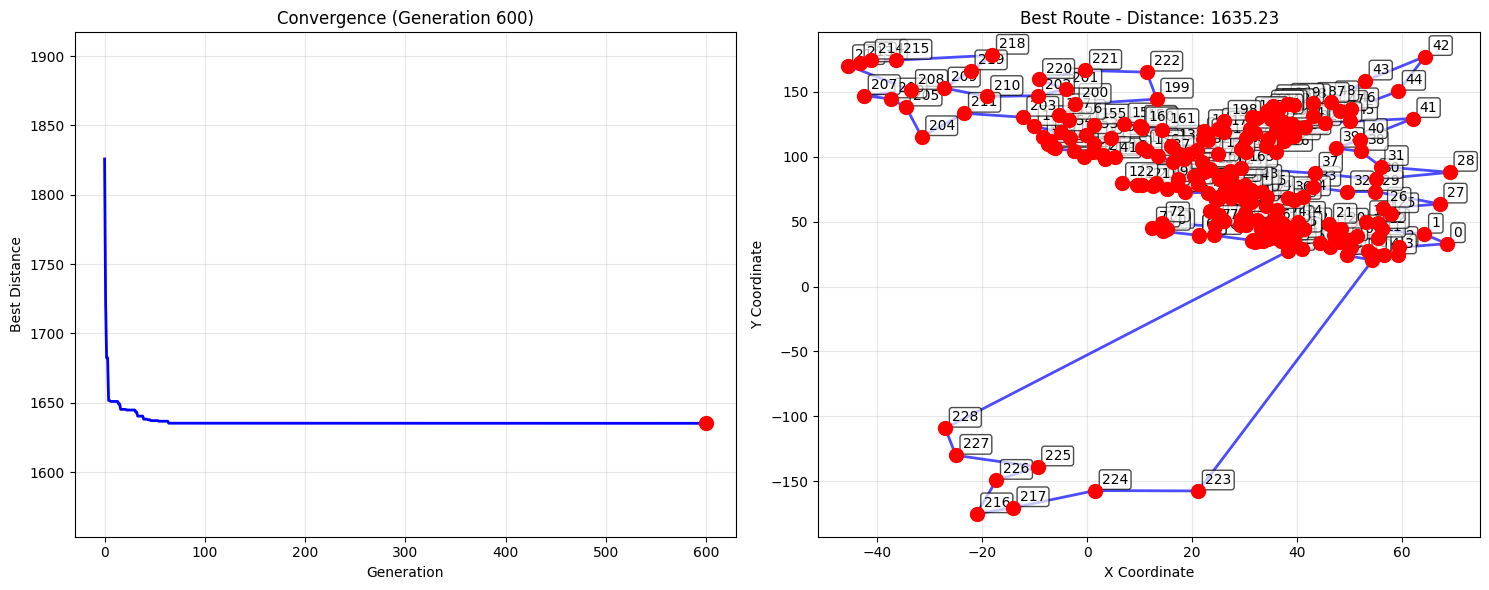

Imagen guardada en out/best3_routegr.png


In [26]:
CITIES_COORDINATES, ADJACENCY_MATRIX = get_adjacency_matrix("data/gr229.tsp")

np.set_printoptions(precision=2, suppress=True)
print("Matriz de adjacencia:")
print(ADJACENCY_MATRIX)
print("\nCoordenadas de cada ciudad:")
print(CITIES_COORDINATES)
NUM_CITIES = len(ADJACENCY_MATRIX)
print("No ciudades:" + str(NUM_CITIES))

gr3 = TSPGeneticAlgorithm(ADJACENCY_MATRIX,CITIES_COORDINATES)
gr3.run()

best_routegr3 = gr3.best_routes_history[-1]

# Distancia total
Dgr3 = calculate_route_distance(best_routegr3, ADJACENCY_MATRIX)
print(f"Distancia total del mejor recorrido: {Dgr3:.2f}")

# Plot results
gr3.plot_convergence()

# Create animation (uncomment to generate GIF)
gr3.create_animation(interval=200, save_path='tsp3_gr_evolution.gif')



best_distancegr3 = min(gr3.best_distances_history)
best_indexgr3 = gr3.best_distances_history.index(best_distancegr3)
best_routegr3 = gr3.best_routes_history[best_indexgr3]

save_best_route_image(CITIES_COORDINATES, best_routegr3, best_distancegr3, "out/best3_routegr.png")


Generación del escenario personalizado

In [27]:
CITIES_COORDINATES, ADJACENCY_MATRIX = get_adjacency_matrix("data/special.tsp")

np.set_printoptions(precision=2, suppress=True)
print("Matriz de adjacencia:")
print(ADJACENCY_MATRIX)
print("\nCoordenadas de cada ciudad:")
print(CITIES_COORDINATES)

Matriz de adjacencia:
[[  1.    29.04  77.41 ...  38.55  86.48 146.59]
 [ 29.04   1.    89.53 ...  24.08  57.88 128.49]
 [ 77.41  89.53   1.   ... 110.89 137.03 124.85]
 ...
 [ 38.55  24.08 110.89 ...   1.    56.74 148.6 ]
 [ 86.48  57.88 137.03 ...  56.74   1.   120.05]
 [146.59 128.49 124.85 ... 148.6  120.05   1.  ]]

Coordenadas de cada ciudad:
[[196.52 133.81]
 [171.93 149.25]
 [174.04  59.74]
 [180.61 163.88]
 [103.47 176.33]
 [132.91 102.24]
 [168.76 188.3 ]
 [121.15  54.39]
 [ 67.44  73.68]
 [151.63 152.27]
 [118.19 113.02]
 [146.44  68.53]
 [181.62 112.44]
 [159.36 106.27]
 [129.8  122.63]
 [ 63.1  147.91]
 [ 72.83 198.72]
 [196.19 122.54]
 [ 90.24 192.65]
 [ 57.72 160.87]
 [ 78.41 195.29]
 [166.5   80.1 ]
 [134.09 157.93]
 [ 90.74 136.67]
 [185.91 179.28]
 [155.17  66.88]
 [ 97.02  64.41]
 [ 61.66 191.74]
 [189.36  74.45]
 [ 70.05  91.8 ]
 [178.91 158.06]
 [164.47 177.14]
 [100.88 192.36]
 [ 94.78  75.15]
 [138.04 107.73]
 [169.59  59.21]
 [141.72 195.4 ]
 [118.15 132.63]
 [1

In [28]:
NUM_CITIES = len(ADJACENCY_MATRIX)
print("No ciudades:" + str(NUM_CITIES))

No ciudades:50


Starting TSP Genetic Algorithm with 50 cities...
Population: 100, Max Iterations: 600
------------------------------------------------------------
Initializing population...
Generation   0: Best Distance = 871.4400
Generation  50: Best Distance = 862.1000
Generation 100: Best Distance = 862.1000
Generation 150: Best Distance = 862.1000
Generation 200: Best Distance = 862.1000
Generation 250: Best Distance = 862.1000
Generation 300: Best Distance = 862.1000
Generation 350: Best Distance = 862.1000
Generation 400: Best Distance = 862.1000
Generation 450: Best Distance = 862.1000
Generation 500: Best Distance = 862.1000
Generation 550: Best Distance = 862.1000

Algorithm completed in 112.491 seconds
Best distance found: 862.1000
Distancia total del mejor recorrido: 862.10


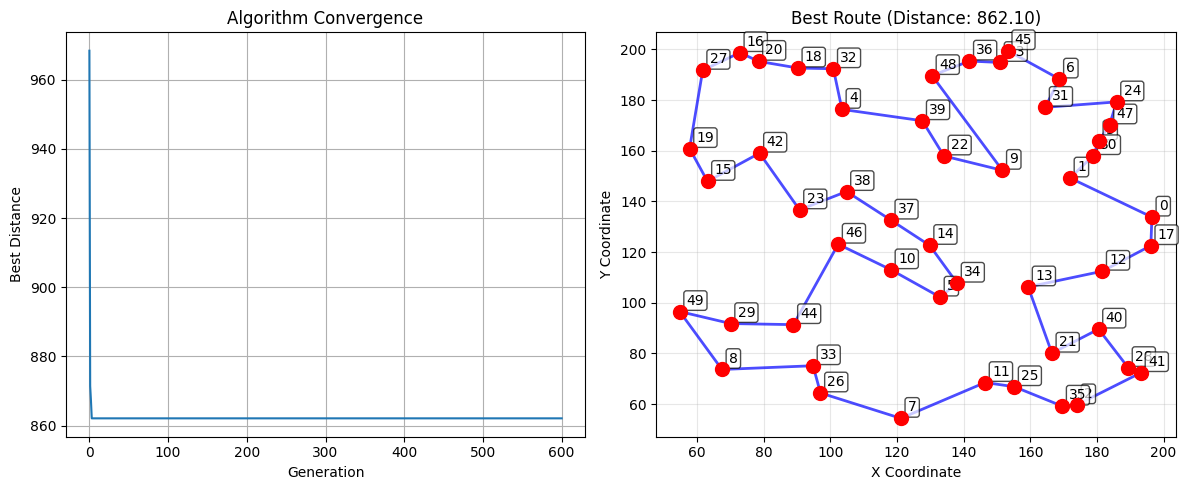

Creating animation...
Saving animation to tsp_custom1_evolution.gif...
Animation saved!


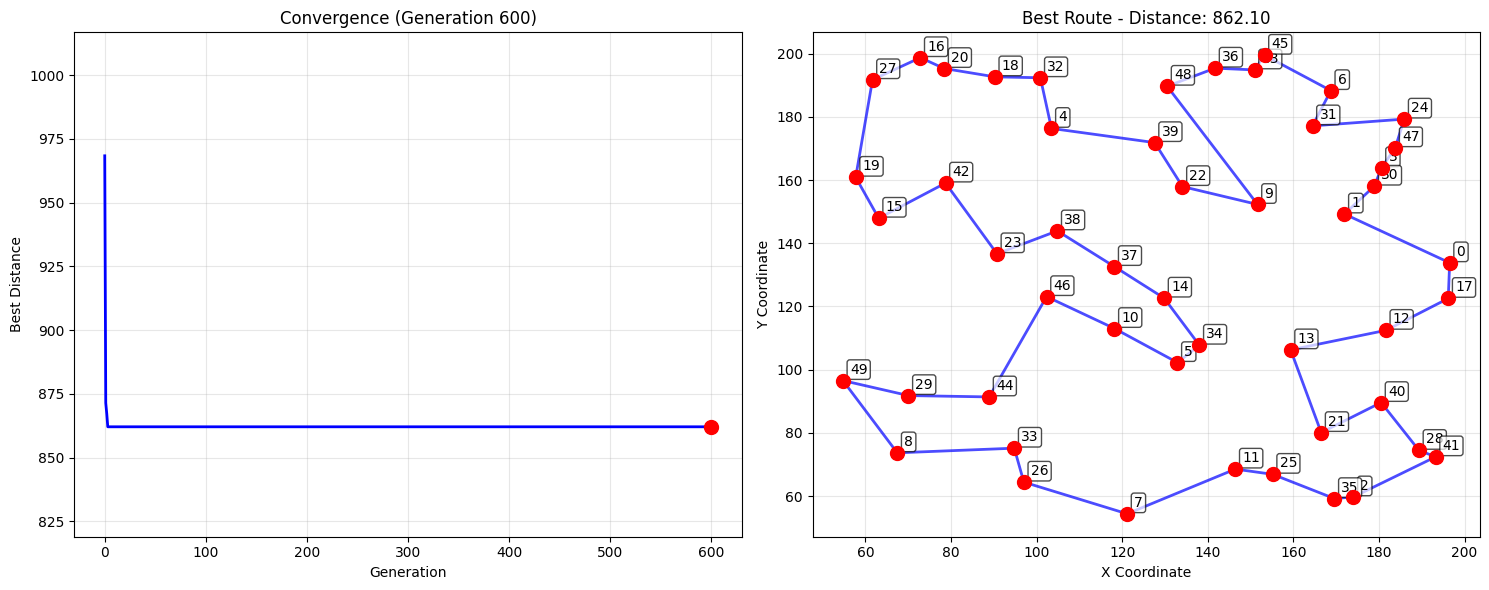

Imagen guardada en out/best_routespe1.png


In [29]:
spe1 = TSPGeneticAlgorithm(ADJACENCY_MATRIX,CITIES_COORDINATES)
spe1.run()

best_routespe1 = spe1.best_routes_history[-1]

# Distancia total
Dspe1 = calculate_route_distance(best_routespe1, ADJACENCY_MATRIX)
print(f"Distancia total del mejor recorrido: {Dspe1:.2f}")

# Plot results
spe1.plot_convergence()

# Create animation (uncomment to generate GIF)
spe1.create_animation(interval=200, save_path='tsp_custom1_evolution.gif')


best_distancespe = min(spe1.best_distances_history)
best_indexspe = spe1.best_distances_history.index(best_distancespe)
best_routespe = spe1.best_routes_history[best_indexspe]


save_best_route_image(CITIES_COORDINATES, best_routespe, best_distancespe, "out/best_routespe1.png")

Escena especial

Matriz de adjacencia:
[[  1.    29.04  77.41 ...  38.55  86.48 146.59]
 [ 29.04   1.    89.53 ...  24.08  57.88 128.49]
 [ 77.41  89.53   1.   ... 110.89 137.03 124.85]
 ...
 [ 38.55  24.08 110.89 ...   1.    56.74 148.6 ]
 [ 86.48  57.88 137.03 ...  56.74   1.   120.05]
 [146.59 128.49 124.85 ... 148.6  120.05   1.  ]]

Coordenadas de cada ciudad:
[[196.52 133.81]
 [171.93 149.25]
 [174.04  59.74]
 [180.61 163.88]
 [103.47 176.33]
 [132.91 102.24]
 [168.76 188.3 ]
 [121.15  54.39]
 [ 67.44  73.68]
 [151.63 152.27]
 [118.19 113.02]
 [146.44  68.53]
 [181.62 112.44]
 [159.36 106.27]
 [129.8  122.63]
 [ 63.1  147.91]
 [ 72.83 198.72]
 [196.19 122.54]
 [ 90.24 192.65]
 [ 57.72 160.87]
 [ 78.41 195.29]
 [166.5   80.1 ]
 [134.09 157.93]
 [ 90.74 136.67]
 [185.91 179.28]
 [155.17  66.88]
 [ 97.02  64.41]
 [ 61.66 191.74]
 [189.36  74.45]
 [ 70.05  91.8 ]
 [178.91 158.06]
 [164.47 177.14]
 [100.88 192.36]
 [ 94.78  75.15]
 [138.04 107.73]
 [169.59  59.21]
 [141.72 195.4 ]
 [118.15 132.63]
 [1

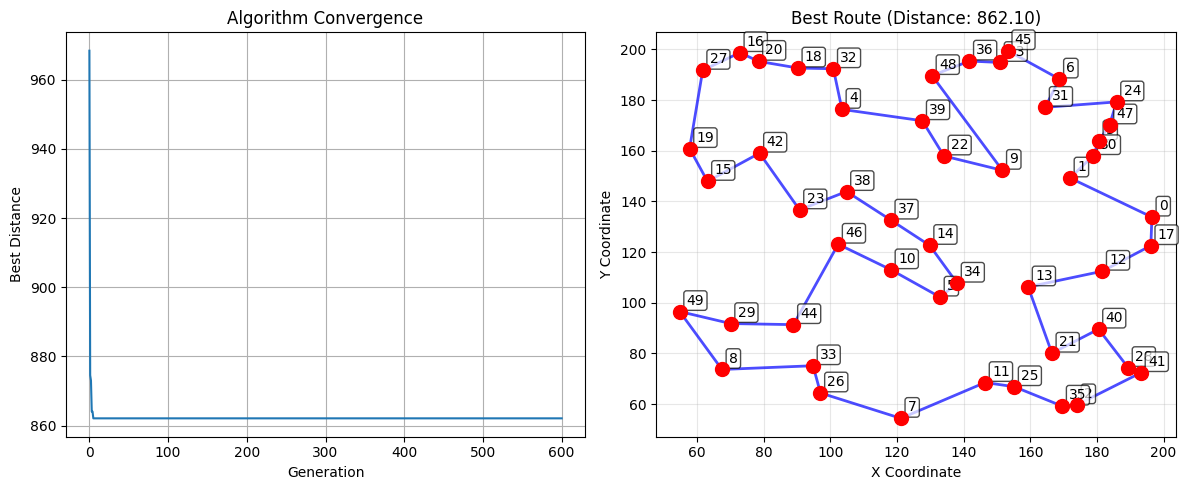

Creating animation...
Saving animation to tsp_custom2_evolution.gif...
Animation saved!


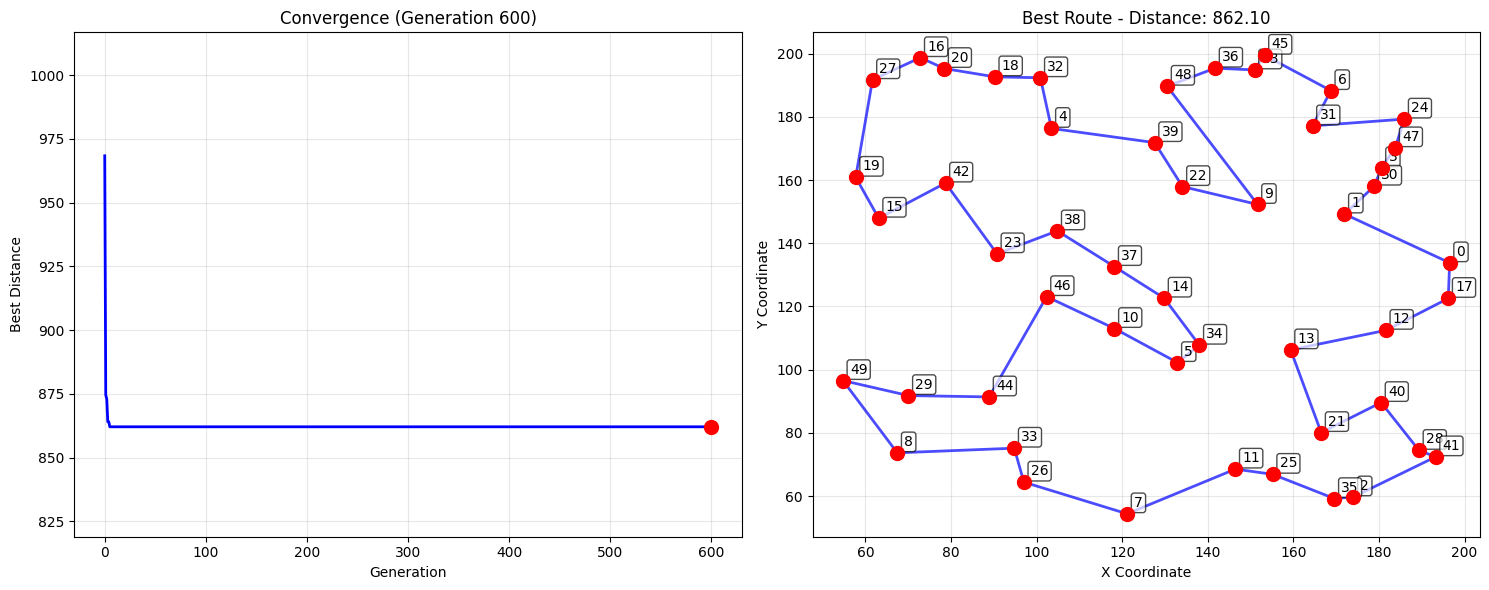

Imagen guardada en out/best_routespe2.png


In [30]:
CITIES_COORDINATES, ADJACENCY_MATRIX = get_adjacency_matrix("data/special.tsp")

np.set_printoptions(precision=2, suppress=True)
print("Matriz de adjacencia:")
print(ADJACENCY_MATRIX)
print("\nCoordenadas de cada ciudad:")
print(CITIES_COORDINATES)

NUM_CITIES = len(ADJACENCY_MATRIX)
print("No ciudades:" + str(NUM_CITIES))

spe2 = TSPGeneticAlgorithm(ADJACENCY_MATRIX,CITIES_COORDINATES)
spe2.run()

best_routespe2 = spe2.best_routes_history[-1]

# Distancia total
Dspe2 = calculate_route_distance(best_routespe2, ADJACENCY_MATRIX)
print(f"Distancia total del mejor recorrido: {Dspe2:.2f}")

# Plot results
spe2.plot_convergence()

# Create animation (uncomment to generate GIF)
spe2.create_animation(interval=200, save_path='tsp_custom2_evolution.gif')


best_distancespe2 = min(spe2.best_distances_history)
best_indexspe2 = spe2.best_distances_history.index(best_distancespe2)
best_routespe2 = spe2.best_routes_history[best_indexspe2]

save_best_route_image(CITIES_COORDINATES, best_routespe2, best_distancespe2, "out/best_routespe2.png")

Matriz de adjacencia:
[[  1.    29.04  77.41 ...  38.55  86.48 146.59]
 [ 29.04   1.    89.53 ...  24.08  57.88 128.49]
 [ 77.41  89.53   1.   ... 110.89 137.03 124.85]
 ...
 [ 38.55  24.08 110.89 ...   1.    56.74 148.6 ]
 [ 86.48  57.88 137.03 ...  56.74   1.   120.05]
 [146.59 128.49 124.85 ... 148.6  120.05   1.  ]]

Coordenadas de cada ciudad:
[[196.52 133.81]
 [171.93 149.25]
 [174.04  59.74]
 [180.61 163.88]
 [103.47 176.33]
 [132.91 102.24]
 [168.76 188.3 ]
 [121.15  54.39]
 [ 67.44  73.68]
 [151.63 152.27]
 [118.19 113.02]
 [146.44  68.53]
 [181.62 112.44]
 [159.36 106.27]
 [129.8  122.63]
 [ 63.1  147.91]
 [ 72.83 198.72]
 [196.19 122.54]
 [ 90.24 192.65]
 [ 57.72 160.87]
 [ 78.41 195.29]
 [166.5   80.1 ]
 [134.09 157.93]
 [ 90.74 136.67]
 [185.91 179.28]
 [155.17  66.88]
 [ 97.02  64.41]
 [ 61.66 191.74]
 [189.36  74.45]
 [ 70.05  91.8 ]
 [178.91 158.06]
 [164.47 177.14]
 [100.88 192.36]
 [ 94.78  75.15]
 [138.04 107.73]
 [169.59  59.21]
 [141.72 195.4 ]
 [118.15 132.63]
 [1

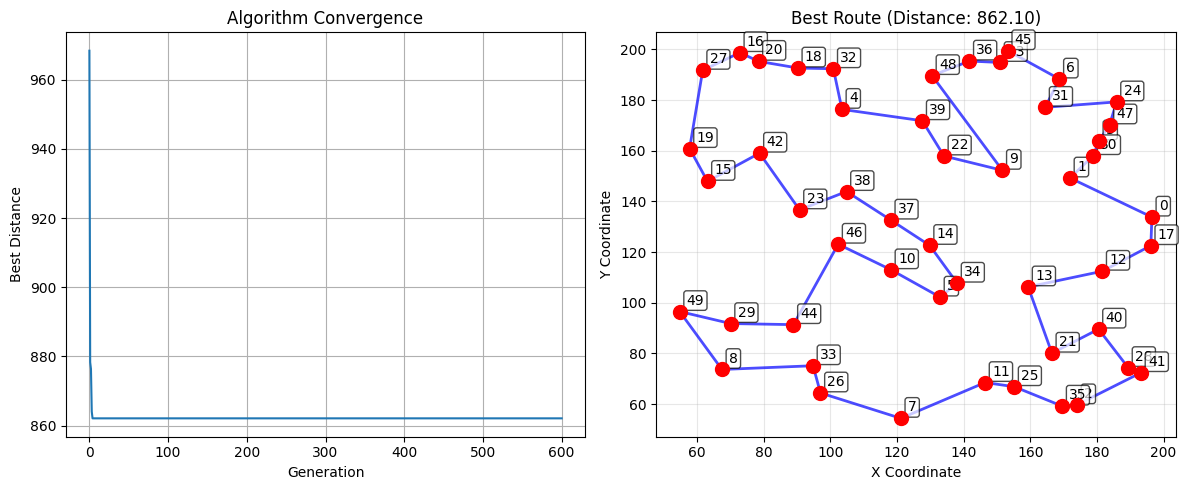

Creating animation...
Saving animation to tsp_custom3_evolution.gif...
Animation saved!


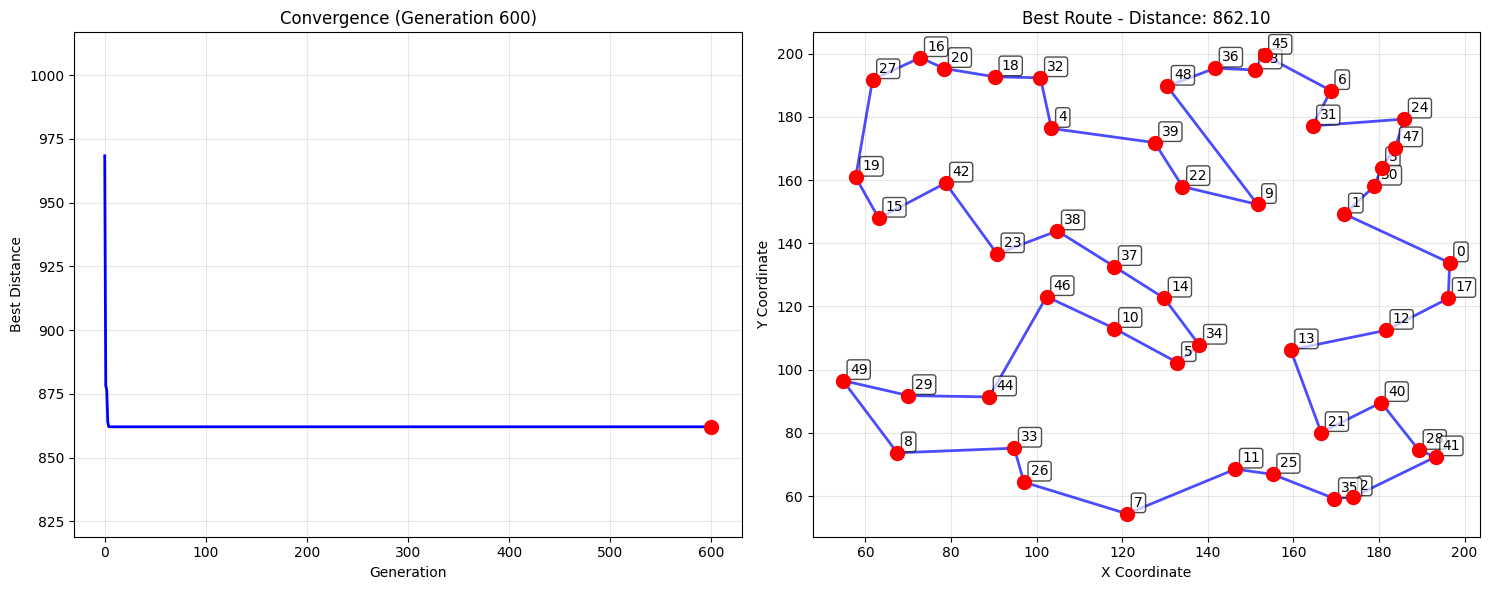

Imagen guardada en out/best_routespe3.png


In [31]:
CITIES_COORDINATES, ADJACENCY_MATRIX = get_adjacency_matrix("data/special.tsp")

np.set_printoptions(precision=2, suppress=True)
print("Matriz de adjacencia:")
print(ADJACENCY_MATRIX)
print("\nCoordenadas de cada ciudad:")
print(CITIES_COORDINATES)

NUM_CITIES = len(ADJACENCY_MATRIX)
print("No ciudades:" + str(NUM_CITIES))

spe3 = TSPGeneticAlgorithm(ADJACENCY_MATRIX,CITIES_COORDINATES)
spe3.run()

best_routespe3 = spe3.best_routes_history[-1]

# Distancia total
Dspe3 = calculate_route_distance(best_routespe3, ADJACENCY_MATRIX)
print(f"Distancia total del mejor recorrido: {Dspe3:.2f}")

# Plot results
spe3.plot_convergence()

# Create animation (uncomment to generate GIF)
spe3.create_animation(interval=200, save_path='tsp_custom3_evolution.gif')


best_distancespe3 = min(spe3.best_distances_history)
best_indexspe3 = spe3.best_distances_history.index(best_distancespe3)
best_routespe3 = spe3.best_routes_history[best_indexspe3]

save_best_route_image(CITIES_COORDINATES, best_routespe3, best_distancespe3, "out/best_routespe3.png")

la ruta de la solución más optima. 

In [32]:
import time
import numpy as np
import pulp

class TSPPuLPSolver:
    def __init__(self, adjacency_matrix, cities_coords=None):
        self.D = np.array(adjacency_matrix, dtype=float)
        self.N = self.D.shape[0]
        self.coords = None if cities_coords is None else np.array(cities_coords, dtype=float)

        # Historiales como en GA
        self.best_routes_history = []         # Mejor ruta en cada paso
        self.best_distances_history = []      # Distancia de esa mejor ruta
        self.top3_routes_history = []         # Lista de top 3 rutas (lista de listas) por paso
        self.top3_distances_history = []      # Lista de distancias de top 3 por paso
        self.distance = 0

        self.solve_time = 0.0
        self.status = None

    def _record_iteration(self, tours):
        """
        Guarda en los historiales la mejor ruta y también las 3 mejores rutas.
        """
        if not tours:
            return
        # Calcular distancias de todas las rutas encontradas
        scored = [(t, self._tour_distance(t)) for t in tours]
        scored.sort(key=lambda x: x[1])  # ordenar por distancia ascendente

        # Top 1
        self.best_routes_history.append(scored[0][0])
        self.best_distances_history.append(scored[0][1])

        # Top 3 (si hay menos, rellena con lo que haya)
        self.top3_routes_history.append([r for r, d in scored[:3]])
        self.top3_distances_history.append([d for r, d in scored[:3]])

    # ---- utilities ----
    def _tour_distance(self, tour):
        d = 0.0
        for i in range(len(tour)):
            a = tour[i]
            b = tour[(i+1) % len(tour)]
            d += self.D[a, b]
        return d

    def _extract_tours_from_x(self, x):
        """Extract all cycles from x[i][j] binary solution (may contain subtours)."""
        N = self.N
        succ = {i: None for i in range(N)}
        for i in range(N):
            for j in range(N):
                if i != j and pulp.value(x[i][j]) > 0.5:
                    succ[i] = j
                    break  # one successor per node
        tours, visited = [], set()
        for start in range(N):
            if start in visited:
                continue
            cur = start
            tour = []
            while cur is not None and cur not in visited:
                visited.add(cur)
                tour.append(cur)
                cur = succ[cur]
            if tour:
                tours.append(tour)
        return tours

    def _add_mtz_constraints(self, model, x):
        """MTZ anti-subtour (u variables)."""
        N = self.N
        u = pulp.LpVariable.dicts("u", range(N), lowBound=0, upBound=N-1, cat="Continuous")
        model += u[0] == 0
        for i in range(1, N):
            for j in range(1, N):
                if i == j:
                    continue
                model += u[i] - u[j] + (N * x[i][j]) <= N - 1
        return u

    def _build_model(self):
        """Create variables + degree constraints + objective."""
        N = self.N
        model = pulp.LpProblem("TSP", pulp.LpMinimize)
        x = {i: {j: None for j in range(N)} for i in range(N)}
        for i in range(N):
            for j in range(N):
                if i == j:
                    continue
                x[i][j] = pulp.LpVariable(f"x_{i}_{j}", lowBound=0, upBound=1, cat="Binary")

        for i in range(N):
            model += pulp.lpSum(x[i][j] for j in range(N) if j != i) == 1  # out degree
        for j in range(N):
            model += pulp.lpSum(x[i][j] for i in range(N) if i != j) == 1  # in degree

        model += pulp.lpSum(self.D[i, j] * x[i][j] for i in range(N) for j in range(N) if i != j)
        return model, x

    def _add_subtour_constraint(self, model, S, x):
        """SEC: sum_{i in S} sum_{j in S, j!=i} x_ij <= |S|-1"""
        model += pulp.lpSum(x[i][j] for i in S for j in S if i != j) <= len(S) - 1

    # ---------- stitching subtours into a single Hamiltonian tour ----------
    def _stitch_subtours_to_path(self, tours):
        """
        Greedy merge of multiple subtours into a single Hamiltonian tour.
        """
        if not tours:
            return []

        # if already single tour covering all nodes:
        if len(tours) == 1 and len(tours[0]) == self.N:
            return tours[0]

        subtours = [list(t) for t in tours]
        merged = subtours.pop(0)

        def best_connection(path_a, path_b):
            a, b = path_a, path_b
            candidates = []
            # a_end -> b_start
            candidates.append((self.D[a[-1], b[0]], a + b))
            # a_end -> b_end (reverse b)
            candidates.append((self.D[a[-1], b[-1]], a + b[::-1]))
            # a_start <- b_start (reverse a, prepend b[::-1])
            candidates.append((self.D[a[0], b[0]], b[::-1] + a))
            # a_start <- b_end (prepend b)
            candidates.append((self.D[a[0], b[-1]], b + a))
            return min(candidates, key=lambda x: x[0])

        while subtours:
            best = None
            best_idx = None
            for idx, t in enumerate(subtours):
                c_cost, c_path = best_connection(merged, t)
                if best is None or c_cost < best[0]:
                    best = (c_cost, c_path)
                    best_idx = idx
            merged = best[1]
            subtours.pop(best_idx)

        # remove duplicates keeping order
        seen, dedup = set(), []
        for v in merged:
            if v not in seen:
                dedup.append(v)
                seen.add(v)

        # insert missing nodes if any
        if len(dedup) < self.N:
            missing = [i for i in range(self.N) if i not in seen]
            for m in missing:
                best_pos, best_increase = 0, float("inf")
                for i in range(len(dedup)):
                    a = dedup[i]
                    b = dedup[(i+1) % len(dedup)]
                    inc = self.D[a, m] + self.D[m, b] - self.D[a, b]
                    if inc < best_increase:
                        best_increase = inc
                        best_pos = i + 1
                dedup.insert(best_pos, m)

        return dedup

    # ---- public API ----
    def solve(self, method="MTZ", time_limit=None, msg=False):
        """
        method: "MTZ" (single solve) or "SEC" (iterative subtour elimination loop).
        time_limit: seconds (sets solver time limit if supported).
        msg: True to print solver logs.
        """
        t0 = time.time()
        if method.upper() == "MTZ":
            self._solve_mtz(time_limit, msg)
        else:
            self._solve_sec_loop(time_limit, msg)
        self.solve_time = time.time() - t0
        return {
            "status": self.status,
            "time": self.solve_time,
            "best_distance": None if not self.best_distances_history else self.best_distances_history[-1],
            "best_route": None if not self.best_routes_history else self.best_routes_history[-1],
        }

    def _solve_mtz(self, time_limit, msg):
        model, x = self._build_model()
        _ = self._add_mtz_constraints(model, x)
        solver = pulp.PULP_CBC_CMD(msg=msg, timeLimit=time_limit)
        model.solve(solver)
        self.status = pulp.LpStatus[model.status]

        tours = self._extract_tours_from_x(x)
        self._record_iteration(tours)

   
    def _solve_sec_loop(self, time_limit, msg):
        start = time.time()
        limit = float("inf") if time_limit is None else time_limit
        model, x = self._build_model()

        while True:
            remaining = max(0, limit - (time.time() - start))
            solver = pulp.PULP_CBC_CMD(msg=msg, timeLimit=None if time_limit is None else remaining)
            model.solve(solver)
            self.status = pulp.LpStatus[model.status]

            tours = self._extract_tours_from_x(x)
            self._record_iteration(tours)

            # Si ya hay un tour único que cubre todo
            if tours and len(tours) == 1:
                break

            # Agregar restricciones de subtour
            for S in tours:
                if 0 < len(S) < self.N:
                    self._add_subtour_constraint(model, S, x)

            if (time.time() - start) >= limit:
                break


    # ---- convenience helpers (plot/animate compatible with your GA) ----
    def get_best(self):
        """Return best_route, best_distance (GA-like convenience)."""
        if not self.best_routes_history:
            return None, None
        idx = int(np.argmin(self.best_distances_history))
        return self.best_routes_history[idx], float(self.best_distances_history[idx])

    def best_hamiltonian_route(self, stitch_if_needed=True):
        """
        Returns a single tour visiting all cities.
        Prefers recorded full tours; otherwise stitches the last subtours.
        """
        if not self.best_routes_history:
            return None, None

        # Prefer full tours already recorded
        candidates = [(r, self._tour_distance(r))
                      for r in self.best_routes_history if len(r) == self.N]
        if candidates:
            route, dist = min(candidates, key=lambda x: x[1])
            return route, float(dist)

        if stitch_if_needed:
            # stitch from last known tours (if SEC loop) or from last route
            last_snapshot = self.best_routes_history[-1]
            stitched = self._stitch_subtours_to_path([last_snapshot])
            if stitched and len(stitched) == self.N:
                return stitched, float(self._tour_distance(stitched))
        return None, None

    def save_best_image(self, out_path):
        """
        Saves an image of a single Hamiltonian tour (stitched if needed).
        """
        assert self.coords is not None, "coords required for visualization"
        route, dist = self.best_hamiltonian_route(stitch_if_needed=True)

        self.distance = dist

        if route is None or len(route) != self.N:
            raise ValueError("Could not build a full Hamiltonian tour for visualization.")

        import matplotlib.pyplot as plt
        from pathlib import Path

        closed = route + [route[0]]
        fig, ax = plt.subplots(figsize=(6,6), dpi=160)
        ax.scatter(self.coords[:,0], self.coords[:,1])
        xs = [self.coords[i,0] for i in closed]
        ys = [self.coords[i,1] for i in closed]
        ax.plot(xs, ys, lw=1.6)
        ax.set_title(f"LP Best Route - D={dist:.2f}")
        ax.set_aspect("equal", adjustable="box")
        ax.grid(True, linestyle="--", linewidth=0.5)

        p = Path(out_path); p.parent.mkdir(parents=True, exist_ok=True)
        fig.tight_layout(); fig.savefig(p, bbox_inches="tight"); plt.close(fig)
        return str(p)

    def create_animation(self, interval=200, save_path=None):
        """
        Minimal animation using best_routes_history.
        """
        from matplotlib import pyplot as plt
        from matplotlib.animation import FuncAnimation

        assert self.coords is not None, "coords required for animation"
        routes = self.best_routes_history
        dists  = self.best_distances_history
        if not routes:
            raise ValueError("No routes to animate. Solve first.")

        fig, ax = plt.subplots(figsize=(6,6), dpi=120)
        ax.scatter(self.coords[:,0], self.coords[:,1])
        path_line, = ax.plot([], [], lw=1.5)
        title = ax.set_title("")

        ax.set_aspect("equal", adjustable="box")
        ax.grid(True, linestyle="--", linewidth=0.5)

        def init():
            path_line.set_data([], [])
            title.set_text("")
            return path_line, title

        def update(frame):
            tour = routes[frame]
            closed = tour + [tour[0]]
            xs = [self.coords[i,0] for i in closed]
            ys = [self.coords[i,1] for i in closed]
            path_line.set_data(xs, ys)
            title.set_text(f"LP Iter {frame+1}/{len(routes)} - D={dists[frame]:.2f}")
            return path_line, title

        anim = FuncAnimation(fig, update, frames=len(routes), init_func=init, interval=interval, blit=True)
        if save_path:
            anim.save(save_path, writer="ffmpeg", fps=max(1, 1000//interval))
            plt.close(fig)
        return anim


In [33]:
CITIES_COORDINATES, ADJACENCY_MATRIX = get_adjacency_matrix("data/special.tsp")

np.set_printoptions(precision=2, suppress=True)
print("Matriz de adjacencia:")
print(ADJACENCY_MATRIX)
print("\nCoordenadas de cada ciudad:")
print(CITIES_COORDINATES)


NUM_CITIES = len(ADJACENCY_MATRIX)
print("No ciudades:" + str(NUM_CITIES))

# Build and solve with PuLP (choose mode)
lpspecial = TSPPuLPSolver(ADJACENCY_MATRIX, cities_coords=CITIES_COORDINATES)
start_time = time.time()
lpspecial.solve(method="SEC", time_limit=60, msg=False)  # o "MTZ"
end_time = time.time()
lpsspecialtime = end_time - start_time
img_path = lpspecial.save_best_image("out/lpspe_best_route.png")
print("Saved:", img_path)
print("Mejor ruta final:", lpspecial.best_routes_history[-1])
print("Top 3 rutas de la última iteración:")



for r, d in zip(lpspecial.top3_routes_history[-1], lpspecial.top3_distances_history[-1]):
    print("Ruta:", r, "Distancia:", d)
    distancia_special = d

Matriz de adjacencia:
[[  1.    29.04  77.41 ...  38.55  86.48 146.59]
 [ 29.04   1.    89.53 ...  24.08  57.88 128.49]
 [ 77.41  89.53   1.   ... 110.89 137.03 124.85]
 ...
 [ 38.55  24.08 110.89 ...   1.    56.74 148.6 ]
 [ 86.48  57.88 137.03 ...  56.74   1.   120.05]
 [146.59 128.49 124.85 ... 148.6  120.05   1.  ]]

Coordenadas de cada ciudad:
[[196.52 133.81]
 [171.93 149.25]
 [174.04  59.74]
 [180.61 163.88]
 [103.47 176.33]
 [132.91 102.24]
 [168.76 188.3 ]
 [121.15  54.39]
 [ 67.44  73.68]
 [151.63 152.27]
 [118.19 113.02]
 [146.44  68.53]
 [181.62 112.44]
 [159.36 106.27]
 [129.8  122.63]
 [ 63.1  147.91]
 [ 72.83 198.72]
 [196.19 122.54]
 [ 90.24 192.65]
 [ 57.72 160.87]
 [ 78.41 195.29]
 [166.5   80.1 ]
 [134.09 157.93]
 [ 90.74 136.67]
 [185.91 179.28]
 [155.17  66.88]
 [ 97.02  64.41]
 [ 61.66 191.74]
 [189.36  74.45]
 [ 70.05  91.8 ]
 [178.91 158.06]
 [164.47 177.14]
 [100.88 192.36]
 [ 94.78  75.15]
 [138.04 107.73]
 [169.59  59.21]
 [141.72 195.4 ]
 [118.15 132.63]
 [1

In [34]:
CITIES_COORDINATES, ADJACENCY_MATRIX = get_adjacency_matrix("data/gr229.tsp")

np.set_printoptions(precision=2, suppress=True)
print("Matriz de adjacencia:")
print(ADJACENCY_MATRIX)
print("\nCoordenadas de cada ciudad:")
print(CITIES_COORDINATES)


NUM_CITIES = len(ADJACENCY_MATRIX)
print("No ciudades:" + str(NUM_CITIES))

# Build and solve with PuLP (choose mode)
lpgr = TSPPuLPSolver(ADJACENCY_MATRIX, cities_coords=CITIES_COORDINATES)
start_time = time.time()
lpgr.solve(method="SEC", time_limit=60, msg=False)  # o "MTZ"
end_time = time.time()
lpgrtime = end_time - start_time
img_path = lpgr.save_best_image("out/lpsgr_best_route.png")
print("Saved:", img_path)


Matriz de adjacencia:
[[  1.     8.42   9.48 ... 201.61 188.07 171.43]
 [  8.42   1.    11.24 ... 206.49 192.4  175.27]
 [  9.48  11.24   1.   ... 195.26 181.17 164.09]
 ...
 [201.61 206.49 195.26 ...   1.    20.77  41.29]
 [188.07 192.4  181.17 ...  20.77   1.    20.94]
 [171.43 175.27 164.09 ...  41.29  20.94   1.  ]]

Coordenadas de cada ciudad:
[[  68.58   33.05]
 [  64.34   40.32]
 [  59.55   30.15]
 [  59.25   24.45]
 [  56.57   24.06]
 [  54.43   20.3 ]
 [  54.41   25.19]
 [  53.54   27.34]
 [  49.5    24.  ]
 [  50.26   30.31]
 [  46.28   30.44]
 [  55.45   37.35]
 [  56.2    44.  ]
 [  55.45   49.08]
 [  53.12   50.09]
 [  51.4    39.1 ]
 [  50.     36.15]
 [  48.27   34.59]
 [  44.36   33.32]
 [  47.14   39.42]
 [  48.44   44.25]
 [  46.21   48.03]
 [  41.43   44.49]
 [  40.11   44.3 ]
 [  40.23   49.51]
 [  58.     56.15]
 [  56.51   60.36]
 [  67.27   63.58]
 [  69.2    88.06]
 [  55.     73.24]
 [  55.02   82.55]
 [  56.01   92.5 ]
 [  49.5    73.1 ]
 [  43.15   76.57]
 [ 

In [35]:
CITIES_COORDINATES, ADJACENCY_MATRIX = get_adjacency_matrix("data/eil101.tsp")

np.set_printoptions(precision=2, suppress=True)
print("Matriz de adjacencia:")
print(ADJACENCY_MATRIX)
print("\nCoordenadas de cada ciudad:")
print(CITIES_COORDINATES)


NUM_CITIES = len(ADJACENCY_MATRIX)
print("No ciudades:" + str(NUM_CITIES))

# Build and solve with PuLP (choose mode)
lpeil = TSPPuLPSolver(ADJACENCY_MATRIX, cities_coords=CITIES_COORDINATES)
start_time = time.time()
lpeil.solve(method="SEC", time_limit=60, msg=False)  # o "MTZ"
end_time = time.time()
lpeiltime = end_time - start_time
img_path = lpeil.save_best_image("out/lpeil_best_route.png")
print("Saved:", img_path)
print("Mejor ruta final:", lpeil.best_routes_history[-1])
print("Top 3 rutas de la última iteración:")
for r, d in zip(lpgr.top3_routes_history[-1], lpeil.top3_distances_history[-1]):
    print("Ruta:", r, "Distancia:", d)
    distancia_eil = d

Matriz de adjacencia:
[[ 1.   32.56 14.56 ... 31.14 38.6  15.23]
 [32.56  1.   34.41 ... 17.49 17.03 18.  ]
 [14.56 34.41  1.   ... 39.82 45.8  22.36]
 ...
 [31.14 17.49 39.82 ...  1.    8.25 17.49]
 [38.6  17.03 45.8  ...  8.25  1.   24.04]
 [15.23 18.   22.36 ... 17.49 24.04  1.  ]]

Coordenadas de cada ciudad:
[[41. 49.]
 [35. 17.]
 [55. 45.]
 [55. 20.]
 [15. 30.]
 [25. 30.]
 [20. 50.]
 [10. 43.]
 [55. 60.]
 [30. 60.]
 [20. 65.]
 [50. 35.]
 [30. 25.]
 [15. 10.]
 [30.  5.]
 [10. 20.]
 [ 5. 30.]
 [20. 40.]
 [15. 60.]
 [45. 65.]
 [45. 20.]
 [45. 10.]
 [55.  5.]
 [65. 35.]
 [65. 20.]
 [45. 30.]
 [35. 40.]
 [41. 37.]
 [64. 42.]
 [40. 60.]
 [31. 52.]
 [35. 69.]
 [53. 52.]
 [65. 55.]
 [63. 65.]
 [ 2. 60.]
 [20. 20.]
 [ 5.  5.]
 [60. 12.]
 [40. 25.]
 [42.  7.]
 [24. 12.]
 [23.  3.]
 [11. 14.]
 [ 6. 38.]
 [ 2. 48.]
 [ 8. 56.]
 [13. 52.]
 [ 6. 68.]
 [47. 47.]
 [49. 58.]
 [27. 43.]
 [37. 31.]
 [57. 29.]
 [63. 23.]
 [53. 12.]
 [32. 12.]
 [36. 26.]
 [21. 24.]
 [17. 34.]
 [12. 24.]
 [24. 58.]
 [2

In [ ]:
import numpy as np
import pandas as pd

# ---------- helpers ----------
def err_pct(found, optimum):
    """Porcentaje de error entre valor encontrado y óptimo."""
    if optimum in [0, None] or np.isnan(optimum) or np.isnan(found):
        return np.nan
    return abs((found - optimum) / optimum) * 100


def coerce_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan


def extract_time(obj):
    """
    Detecta el atributo de tiempo dentro del objeto del escenario.
    Ahora incluye .timeduration como principal.
    """
    for attr in ["timeduration", "time", "tiempo", "execution_time", "total_time"]:
        if hasattr(obj, attr):
            val = getattr(obj, attr)
            return coerce_float(val)
    return np.nan


def build_rows(instance_name, scenarios, lp_optimum, lp_time):
    """
    instance_name: 'SPE', 'GR', 'EIL'
    scenarios: lista de objetos [spe1, spe2, spe3]
    """
    rows = []

    for idx, scenario in enumerate(scenarios, start=1):
        scenario_name = f"{instance_name}{idx}"

        # Fila LP (óptima)
        rows.append({
            "Instancia": instance_name,
            "Escenario": scenario_name,
            "Tipo de solución": "LP (Óptima)",
            "Iteración": "-",
            "Tiempo de ejecución (s)": coerce_float(lp_time),
            "Solución óptima teórica": coerce_float(lp_optimum),
            "Solución subóptima encontrada": "-",
            "Porcentaje de error (%)": 0.0,
        })

        # Extraer distancias y tiempo
        dists = getattr(scenario, "distances", [])
        escenario_tiempo = extract_time(scenario)

        # Convertir a lista numérica
        if isinstance(dists, (np.ndarray, list, tuple)):
            dists = [coerce_float(d) for d in dists]
        else:
            dists = [coerce_float(dists)]

        # Registrar cada iteración GA
        for i, d in enumerate(dists, start=1):
            rows.append({
                "Instancia": instance_name,
                "Escenario": scenario_name,
                "Tipo de solución": "GA",
                "Iteración": i,
                "Tiempo de ejecución (s)": escenario_tiempo,
                "Solución óptima teórica": coerce_float(lp_optimum),
                "Solución subóptima encontrada": coerce_float(d),
                "Porcentaje de error (%)": err_pct(coerce_float(d), coerce_float(lp_optimum)),
            })

    return rows


# ---------- build full table ----------
# Se asume que ya tienes:
# spe1, spe2, spe3
# gr1, gr2, gr3
# eil1, eil2, eil3
# LP óptimos: distancia_special, distancia_gr, distancia_eil
# LP tiempos: lpsspecialtime, lpgrtime, lpeiltime

all_rows = []
all_rows += build_rows("SPE", [spe1, spe2, spe3], lpspecial.distance, lpsspecialtime)
all_rows += build_rows("GR",  [gr1,  gr2,  gr3],  lpgr.distance,     lpgrtime)
all_rows += build_rows("EIL", [eil1, eil2, eil3], distancia_eil,    lpeiltime)

tabla_comparacion = pd.DataFrame(all_rows)

# ---------- formatting ----------
num_cols = [
    "Tiempo de ejecución (s)",
    "Solución óptima teórica",
    "Solución subóptima encontrada",
    "Porcentaje de error (%)"
]
tabla_comparacion[num_cols] = tabla_comparacion[num_cols].apply(pd.to_numeric, errors="coerce")

tabla_comparacion = tabla_comparacion.round({
    "Tiempo de ejecución (s)": 4,
    "Solución óptima teórica": 4,
    "Solución subóptima encontrada": 4,
    "Porcentaje de error (%)": 2,
})

tabla_comparacion = tabla_comparacion.sort_values(
    by=["Instancia", "Escenario", "Tipo de solución", "Iteración"],
    kind="stable"
).reset_index(drop=True)

print("=== TABLA COMPLETA ===")
print(tabla_comparacion)

# ---------- resumen (mejor GA por escenario) ----------
resumen = (
    tabla_comparacion[tabla_comparacion["Tipo de solución"] == "GA"]
    .sort_values(by=["Instancia", "Escenario", "Porcentaje de error (%)"])
    .groupby(["Instancia", "Escenario"], as_index=False)
    .first()[[
        "Instancia",
        "Escenario",
        "Tiempo de ejecución (s)",
        "Solución óptima teórica",
        "Solución subóptima encontrada",
        "Porcentaje de error (%)",
    ]]
)

print("\n=== RESUMEN (Mejor GA por escenario) ===")
resumen

# Optional exports
# tabla_comparacion.to_excel("comparacion_LP_vs_GA_por_escenario.xlsx", index=False)
# resumen.to_excel("resumen_mejor_GA_por_escenario.xlsx", index=False)


=== TABLA COMPLETA ===
    Instancia Escenario Tipo de solución Iteración  Tiempo de ejecución (s)  \
0         EIL      EIL1               GA         1                 979.9497   
1         EIL      EIL1               GA         2                 979.9497   
2         EIL      EIL1               GA         3                 979.9497   
3         EIL      EIL1               GA         4                 979.9497   
4         EIL      EIL1               GA         5                 979.9497   
..        ...       ...              ...       ...                      ...   
112       SPE      SPE3               GA         9                 102.3583   
113       SPE      SPE3               GA        10                 102.3583   
114       SPE      SPE3               GA        11                 102.3583   
115       SPE      SPE3               GA        12                 102.3583   
116       SPE      SPE3      LP (Óptima)         -                   4.9414   

     Solución óptima teórica

,Instancia,Escenario,Tiempo de ejecución (s),Solución óptima teórica,Solución subóptima encontrada,Porcentaje de error (%)
0,EIL,EIL1,979.9497,640.13,640.13,0.00
1,EIL,EIL2,1219.1264,640.13,641.98,0.29
2,EIL,EIL3,1224.1480,640.13,640.13,0.00
3,GR,GR1,5709.5138,1921.60,1721.34,10.42
4,GR,GR2,5059.6165,1921.60,1715.64,10.72
5,GR,GR3,2764.8705,1921.60,1722.97,10.34
6,SPE,SPE1,112.4914,862.10,862.10,0.00
7,SPE,SPE2,117.6491,862.10,862.10,0.00
8,SPE,SPE3,102.3583,862.10,862.10,0.00


: 